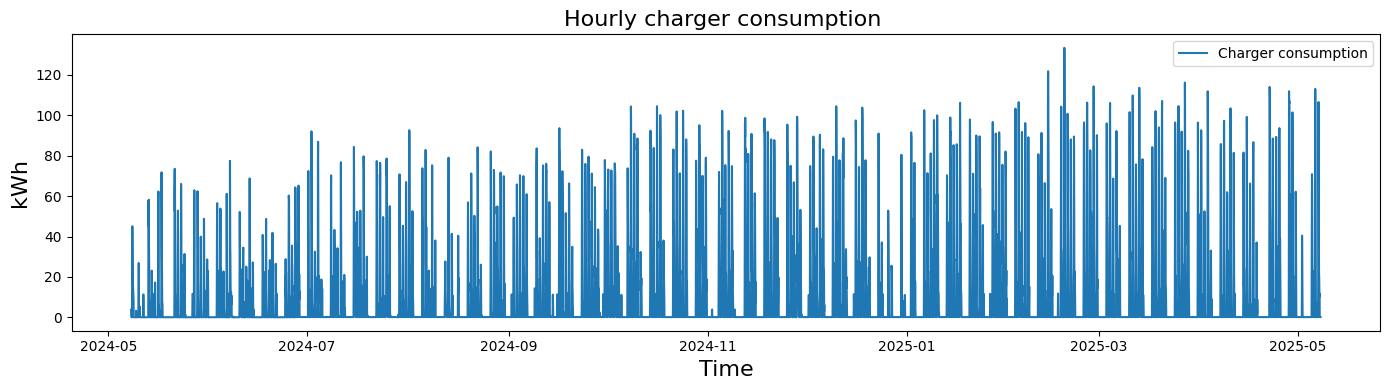

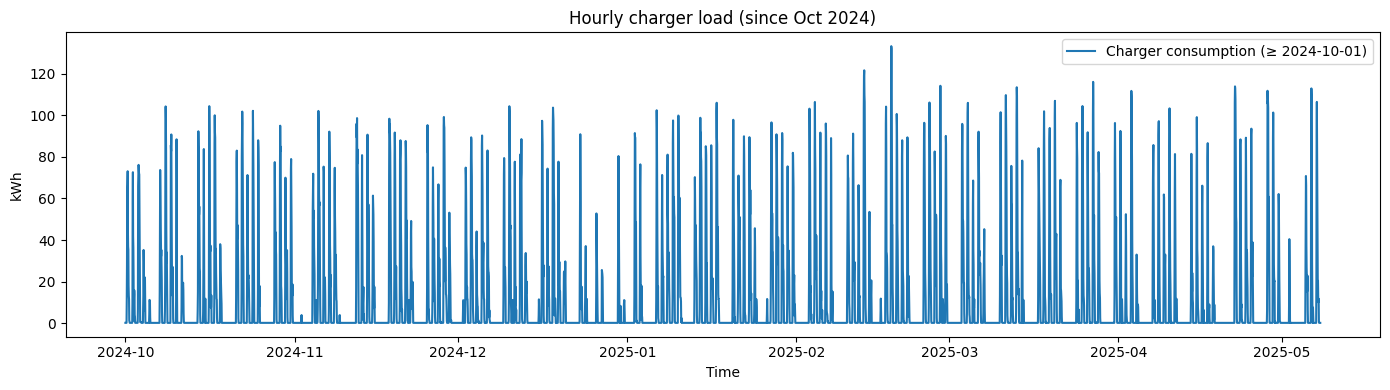

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from pandas import read_csv
from datetime import datetime
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

# ----------------- load & index ---------------------------------
df = (pd.read_csv("./Charging_data_cleaned.csv",  # adjust path
                  parse_dates=["Date"])
        .set_index("Date")
        .sort_index())
'''
df = df.asfreq("h")                      # full hourly grid
df["raw"] = df["Chargers"]               # untouched copy

# ------------- build a year-month-hour key -----------------------
key = df.index.strftime("%Y-%m-%H")      # e.g. "2024-07-15"

# mean Chargers for each (year-month, hour-of-day) bucket
ymh_mean = df.groupby(key)["raw"].transform("mean")

# ------------------ gap filling ---------------------------------
df["Chargers"] = df["raw"].fillna(ymh_mean)
assert not df["Chargers"].isna().any(), "Still have gaps!"
'''
# ------------------ PLOT ----------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["Chargers"], label="Charger consumption")
plt.title("Hourly charger consumption ", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.ylabel("kWh", fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()

# ------------------ PLOT: since 2024-10 --------------------------
cutoff = "2024-10-01"            # YYYY-MM-DD string works with DatetimeIndex
recent = df.loc[cutoff:]         # same as df[df.index >= cutoff]

plt.figure(figsize=(14, 4))
plt.plot(recent.index, recent["Chargers"],
         label=f"Charger consumption (≥ {cutoff})")
plt.title("Hourly charger load (since Oct 2024)")
plt.xlabel("Time")
plt.ylabel("kWh")
plt.tight_layout()
plt.legend()
plt.show()



Mean-of-100-days →  MAE =   8.91   RMSE =  20.07   R² =   0.58


C:\Users\user\AppData\Local\Temp\ipykernel_10608\2429303867.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(idx_start, periods=FORECAST_HR, freq="H")


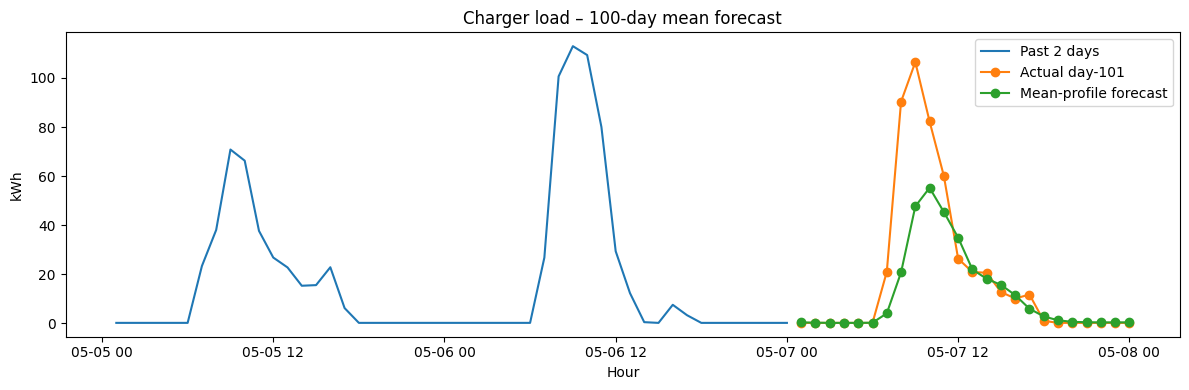

In [2]:
# ───────────────────────── IMPORTS ─────────────────────────
import math
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────────────────── CONFIG ─────────────────────────
TARGET_COL    = "Chargers"
DAYS_TRAIN    = 175                 # ← 100-day training window
HRS_PER_DAY   = 24
LOOK_BACK     = DAYS_TRAIN * HRS_PER_DAY        # 100 × 24 = 2 400 h
FORECAST_HR   = 24                              # 1-day forecast
SHOW_DAYS     = 2                               # how many past days to draw

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # -------- df must already be in memory --------
    needed_rows = LOOK_BACK + FORECAST_HR         # 2 424 rows required
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")
    
    # if you want to change the forecast date
    df_less = df.iloc[:]

    # keep the last 101 days (100 for training + 1 for truth/forecast)
    df_recent = df_less.iloc[-needed_rows:]

    # split 100-day history vs. day-101 truth
    df_hist = df_recent.iloc[:LOOK_BACK]          # rows 0 … 2 399
    df_real = df_recent.iloc[LOOK_BACK:]          # rows 2 400 … 2 423
    y_true  = df_real[TARGET_COL].values

    # ---------- mean-of-period forecast ----------
    hist_matrix = df_hist[TARGET_COL].values.reshape(DAYS_TRAIN, HRS_PER_DAY)
    preds = hist_matrix.mean(axis=0)              # length-24 vector

    idx_start = df_hist.index[-1] + timedelta(hours=1)
    pred_avg = pd.Series(
        preds,
        index=pd.date_range(idx_start, periods=FORECAST_HR, freq="H")
    )

    # ------------- evaluation metrics -------------
    mae  = mean_absolute_error(y_true, pred_avg.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred_avg.values))
    r2   = r2_score(y_true, pred_avg.values)
    print(f"Mean-of-100-days →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R² = {r2:6.2f}")

    # ------------------- plot ---------------------
    past_to_show = df_hist.iloc[-SHOW_DAYS*HRS_PER_DAY:][TARGET_COL]  # last 3 × 24 rows
    actual = df_real[TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(past_to_show.index, past_to_show.values,        label=f"Past {SHOW_DAYS} days")
    plt.plot(actual.index,     actual.values,  "-o",         label="Actual day-101")
    plt.plot(pred_avg.index,   pred_avg.values, "-o",        label="Mean-profile forecast")
    plt.title("Charger load – 100-day mean forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


Weekday-aware mean →  MAE =   5.94   RMSE =  12.14   R² =   0.85


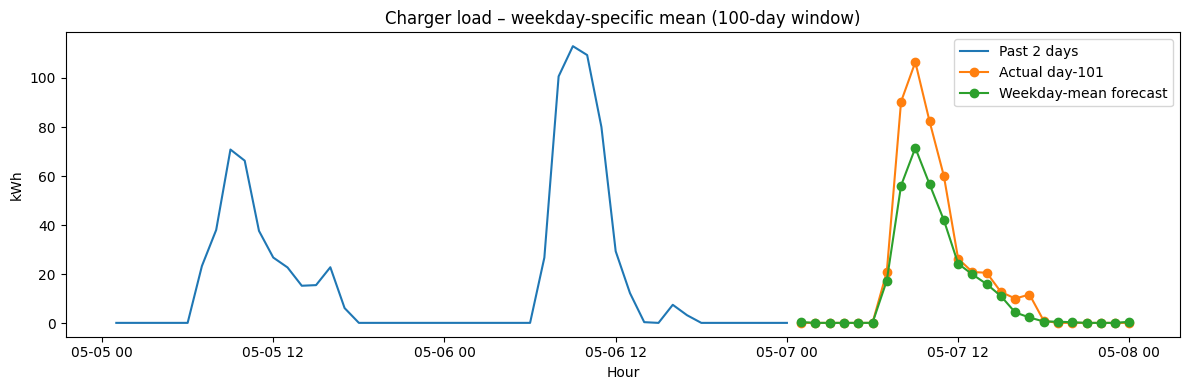

In [3]:
# ───────────────────────── IMPORTS ─────────────────────────
import math
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────────────────── CONFIG ─────────────────────────
TARGET_COL  = "Chargers"
DAYS_BACK   = 175          # how far to look back
HRS_PER_DAY = 24
FORECAST_HR = 24               # 1-day forecast horizon
SHOW_DAYS   = 2              # how many past days to draw

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # need 100 days of history + 1 day of truth
    needed_rows = DAYS_BACK * HRS_PER_DAY + FORECAST_HR
    '''
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")
    '''

    # if you want to change the forecast date
    df_less = df.iloc[:]

    # keep the last 101 days (100 for training + 1 for truth/forecast)
    df_recent = df_less.iloc[-needed_rows:]

    # history vs. truth
    df_hist = df_recent.iloc[: DAYS_BACK * HRS_PER_DAY]    # 100 days
    df_real = df_recent.iloc[DAYS_BACK * HRS_PER_DAY :]    # forecast target (24 h)
    y_true  = df_real[TARGET_COL].values

    # -------- weekday-specific mean profiles --------
    n_weeks      = DAYS_BACK // 7          # 14 complete weeks inside 100 days
    hours_per_wd = n_weeks * HRS_PER_DAY   # 14 × 24 = 336 samples per weekday

    profiles = {}                          # weekday → 24-vector
    for wd in range(7):                    # 0 = Mon … 6 = Sun
        sel = df_hist[df_hist.index.weekday == wd][TARGET_COL].tail(hours_per_wd)
        if len(sel) < hours_per_wd:        # not enough full weeks? skip / fallback
            continue
        # reshape: (n_weeks, 24) then average down the weeks axis
        profiles[wd] = sel.values.reshape(n_weeks, HRS_PER_DAY).mean(axis=0)

    # fallback in case a profile is missing (rare)
    overall_profile = df_hist[TARGET_COL].values.reshape(-1, HRS_PER_DAY).mean(axis=0)

    # -------- choose the profile for the day we’re forecasting --------
    next_day_start = df_hist.index[-1] + timedelta(hours=1)       # first hr to predict
    next_wd        = next_day_start.weekday()
    preds          = profiles.get(next_wd, overall_profile)       # fallback to overall

    pred_avg = pd.Series(
        preds,
        index=pd.date_range(next_day_start, periods=FORECAST_HR, freq="h")
    )

    # -------- evaluation --------
    mae  = mean_absolute_error(y_true, pred_avg.values)
    rmse = math.sqrt(mean_squared_error(y_true, pred_avg.values))
    r2   = r2_score(y_true, pred_avg.values)
    print(f"Weekday-aware mean →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R² = {r2:6.2f}")

    # -------- plot (last 3 days + forecast) --------
    past_to_show = df_hist.iloc[-SHOW_DAYS * HRS_PER_DAY:][TARGET_COL]
    actual       = df_real[TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(past_to_show.index, past_to_show.values, label=f"Past {SHOW_DAYS} days")
    plt.plot(actual.index,      actual.values,      "-o", label="Actual day-101")
    plt.plot(pred_avg.index,    pred_avg.values,    "-o", label="Weekday-mean forecast")
    plt.title("Charger load – weekday-specific mean (100-day window)")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
# ───────────── imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# ───────────── config
TARGET_COL    = "Chargers"
DAYS_TRAIN    = 175          # history length (business days)
HRS_PER_DAY   = 24
LOOK_BACK     = DAYS_TRAIN * HRS_PER_DAY
FORECAST_DAYS = 30           # rolling back-test length (business days)
HOLIDAYS      = [pd.to_datetime("2025-04-21").date()]

# ------------------------------------------------------------------------------
# helper: build weekday → 24-hour mean profiles
# ------------------------------------------------------------------------------
def weekday_profiles(df_hist: pd.DataFrame) -> tuple[dict[int, np.ndarray], np.ndarray]:
    """
    Return a dictionary of weekday-specific hourly means and an overall fallback.
    df_hist must be *business days only*.
    """
    profiles = {}
    # overall weekday mean per hour (as fallback for missing weekdays)
    overall = (
        df_hist.groupby(df_hist["ds"].dt.hour)["y"]
        .mean()
        .reindex(range(24))
        .values
    )

    for wd in range(5):  # 0=Mon … 4=Fri
        sel = df_hist[df_hist["ds"].dt.dayofweek == wd]
        if sel.empty:
            continue
        profiles[wd] = (
            sel.groupby(sel["ds"].dt.hour)["y"]
            .mean()
            .reindex(range(24))
            .values
        )
    return profiles, overall


# ------------------------------------------------------------------------------
# MAIN
# ------------------------------------------------------------------------------
if __name__ == "__main__":

    # --- 1) bring data into Prophet-compatible layout: timestamp → 'ds', target → 'y'
    df_all = df.copy()
    if isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.reset_index()
        df_all.rename(columns={df_all.columns[0]: "ds"}, inplace=True)
    else:
        if df_all.columns[0] != "ds":
            df_all.rename(columns={df_all.columns[0]: "ds"}, inplace=True)
    df_all["ds"] = pd.to_datetime(df_all["ds"])

    # choose the y column
    data_cols = [c for c in df_all.columns if c != "ds"]
    if TARGET_COL in data_cols:
        source_col = TARGET_COL
    elif len(data_cols) == 1:
        source_col = data_cols[0]
        print(f"WARNING: TARGET_COL '{TARGET_COL}' not found. Using '{source_col}' as y.")
    else:
        raise KeyError(f"TARGET_COL '{TARGET_COL}' not found. Available: {data_cols}")
    df_all.rename(columns={source_col: "y"}, inplace=True)

    # --- 2) holiday zeroes + drop weekends
    df_all.loc[df_all["ds"].dt.date.isin(HOLIDAYS), "y"] = 0
    df_all = df_all[df_all["ds"].dt.dayofweek < 5].reset_index(drop=True)

    # --- 3) keep only the last LOOK_BACK hours + back-test span
    total_hours = LOOK_BACK + FORECAST_DAYS * HRS_PER_DAY
    df_recent = df_all.iloc[-total_hours:].reset_index(drop=True)

    unique_days    = np.sort(df_recent["ds"].dt.normalize().unique())
    forecast_days  = unique_days[-FORECAST_DAYS:]           # last 30 business days

    # storage for per-hour and per-day results
    records = []

    # ───────────── rolling back-test ─────────────
    for target_day in forecast_days:
        # split train / test
        train_df = df_recent[df_recent["ds"] < target_day]
        test_mask = (
            (df_recent["ds"] >= target_day)
            & (df_recent["ds"] < target_day + pd.Timedelta(days=1))
        )
        test_df = df_recent[test_mask]

        # --- build weekday profiles on *training* portion
        profiles, overall_profile = weekday_profiles(train_df)

        # --- produce the 24-hour forecast
        weekday_idx = pd.to_datetime(target_day).dayofweek
        y_pred = profiles.get(weekday_idx, overall_profile).copy()

        # night zeros + holiday zeros
        hours = test_df["ds"].dt.hour.values
        night_mask = (hours >= 18) | (hours < 6)
        y_pred[night_mask] = 0
        if pd.to_datetime(target_day).date() in HOLIDAYS:
            y_pred[:] = 0

        y_true = test_df["y"].values

        # metrics
        mae = mean_absolute_error(y_true, y_pred)
        mean_true = y_true.mean() if y_true.mean() != 0 else np.nan
        nmae = mae / mean_true if mean_true else np.nan
        r2_raw = r2_score(y_true, y_pred)
        r2 = max(r2_raw, 0)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        # store per-hour + per-day
        for ds_val, actual, pred in zip(test_df["ds"], y_true, y_pred):
            records.append(
                {
                    "ds": ds_val,
                    "actual": actual,
                    "forecast": pred,
                    "date": target_day,
                    "day_mae": mae,
                    "day_nmae": nmae,
                    "day_r2": r2,
                    "day_mape": mape,
                }
            )

        print(
            f"Day {pd.to_datetime(target_day).date()} → "
            f"MAE={mae:.2f}, NMAE={nmae:.3f}, "
            f"R²={r2:.2f} (raw {r2_raw:.2f}), MAPE={mape:.2f}%"
        )

    # --- 4) assemble results
    results = pd.DataFrame(records)

    # ------------------------------------------------------------------------------
    # PLOTS (identical to earlier version, plus box-plot)
    # ------------------------------------------------------------------------------

    # Plot 1 – Actual vs forecast (all hours)
    plt.figure(figsize=(14, 5))
    plt.plot(results["ds"], results["actual"], label="Actual")
    plt.plot(results["ds"], results["forecast"], label="Weekday-mean baseline", alpha=0.7)
    plt.title(f"Weekday-Mean Baseline – Last {FORECAST_DAYS} Business Days")
    plt.xlabel("Timestamp"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

    # helper frames
    daily_err   = results[["date", "day_mae"]].drop_duplicates().sort_values("date")
    daily_nmae  = results[["date", "day_nmae"]].drop_duplicates().sort_values("date")
    daily_r2    = results[["date", "day_r2"]].drop_duplicates().sort_values("date")
    daily_mape  = results[["date", "day_mape"]].drop_duplicates().sort_values("date")

    # Daily MAE
    plt.figure(figsize=(10, 4))
    plt.plot(daily_err["date"], daily_err["day_mae"], marker="o")
    plt.title("Daily MAE"); plt.xlabel("Date"); plt.ylabel("MAE")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    # Daily NMAE
    plt.figure(figsize=(10, 4))
    plt.plot(daily_nmae["date"], daily_nmae["day_nmae"], marker="o")
    plt.title("Daily Normalised MAE"); plt.xlabel("Date"); plt.ylabel("NMAE")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    # Daily R²
    plt.figure(figsize=(10, 4))
    plt.plot(daily_r2["date"], daily_r2["day_r2"], marker="o")
    plt.title("Daily R² (non-negative)"); plt.xlabel("Date"); plt.ylabel("R²")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    # Averages by weekday (MAE / NMAE / MAPE / R²)
    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

    def bar_with_labels(series, title, ylab, fmt="%.2f"):
        fig, ax = plt.subplots(figsize=(10, 4))
        series = series.reindex(weekday_order)
        bars = ax.bar(series.index, series.values)
        ax.bar_label(
            bars,
            labels=[fmt % v for v in series.values],
            padding=0,
            fontsize=10,
            fontweight="bold",
        )
        ax.set_title(title); ax.set_xlabel("Weekday"); ax.set_ylabel(ylab)
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter(fmt))
        plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    bar_with_labels(
        daily_err.assign(weekday=lambda d: pd.to_datetime(d["date"]).dt.day_name())
        .groupby("weekday")["day_mae"]
        .mean(),
        "Average MAE by Weekday",
        "MAE",
        "%.2f",
    )
    bar_with_labels(
        daily_nmae.assign(weekday=lambda d: pd.to_datetime(d["date"]).dt.day_name())
        .groupby("weekday")["day_nmae"]
        .mean(),
        "Average Normalised MAE by Weekday",
        "NMAE",
        "%.3f",
    )
    bar_with_labels(
        daily_mape.assign(weekday=lambda d: pd.to_datetime(d["date"]).dt.day_name())
        .groupby("weekday")["day_mape"]
        .mean(),
        "Average MAPE by Weekday",
        "MAPE (%)",
        "%.2f",
    )
    bar_with_labels(
        daily_r2.assign(weekday=lambda d: pd.to_datetime(d["date"]).dt.day_name())
        .groupby("weekday")["day_r2"]
        .mean(),
        "Average R² by Weekday",
        "R²",
        "%.2f",
    )

    # Box-plot (MAE & R² per day)
    plt.figure(figsize=(6, 4))
    plt.boxplot(
        [daily_err["day_mae"], daily_r2["day_r2"]],
        labels=["MAE", "R²"],
        showfliers=False,
    )
    plt.title("Distribution of Daily MAE and R² – Weekday-Mean Baseline")
    plt.tight_layout(); plt.show()

    # Overall averages
    print("\n───────── Baseline averages over the 30-day back-test ─────────")
    print(f"MAE : {daily_err['day_mae'].mean():.2f}")
    print(f"NMAE: {daily_nmae['day_nmae'].mean():.3f}")
    print(f"MAPE: {daily_mape['day_mape'].mean():.2f}%")
    print(f"R²  : {daily_r2['day_r2'].mean():.2f}")


Day 2025-03-28 → MAE=7.67, NMAE=0.446, R²=0.67 (raw 0.67), MAPE=198.01%
Day 2025-03-31 → MAE=4.99, NMAE=0.239, R²=0.90 (raw 0.90), MAPE=76.97%
Day 2025-04-01 → MAE=4.85, NMAE=0.322, R²=0.87 (raw 0.87), MAPE=917.03%
Day 2025-04-02 → MAE=6.72, NMAE=0.995, R²=0.39 (raw 0.39), MAPE=932.63%
Day 2025-04-03 → MAE=7.93, NMAE=0.332, R²=0.84 (raw 0.84), MAPE=332.92%
Day 2025-04-04 → MAE=5.29, NMAE=1.011, R²=0.06 (raw 0.06), MAPE=893.23%
Day 2025-04-07 → MAE=5.43, NMAE=0.341, R²=0.88 (raw 0.88), MAPE=151.66%
Day 2025-04-08 → MAE=6.15, NMAE=0.336, R²=0.90 (raw 0.90), MAPE=963.73%
Day 2025-04-09 → MAE=5.21, NMAE=0.419, R²=0.75 (raw 0.75), MAPE=304.41%
Day 2025-04-10 → MAE=6.49, NMAE=0.388, R²=0.90 (raw 0.90), MAPE=743.03%
Day 2025-04-11 → MAE=4.08, NMAE=0.335, R²=0.88 (raw 0.88), MAPE=164.75%
Day 2025-04-14 → MAE=5.42, NMAE=0.430, R²=0.70 (raw 0.70), MAPE=224.43%
Day 2025-04-15 → MAE=5.48, NMAE=0.357, R²=0.90 (raw 0.90), MAPE=283.38%
Day 2025-04-16 → MAE=3.27, NMAE=0.319, R²=0.91 (raw 0.91), MAPE=1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 24 but corresponding boolean dimension is 1

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AR(24) →  MAE = 6.30   RMSE = 10.54   R² = 0.89


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


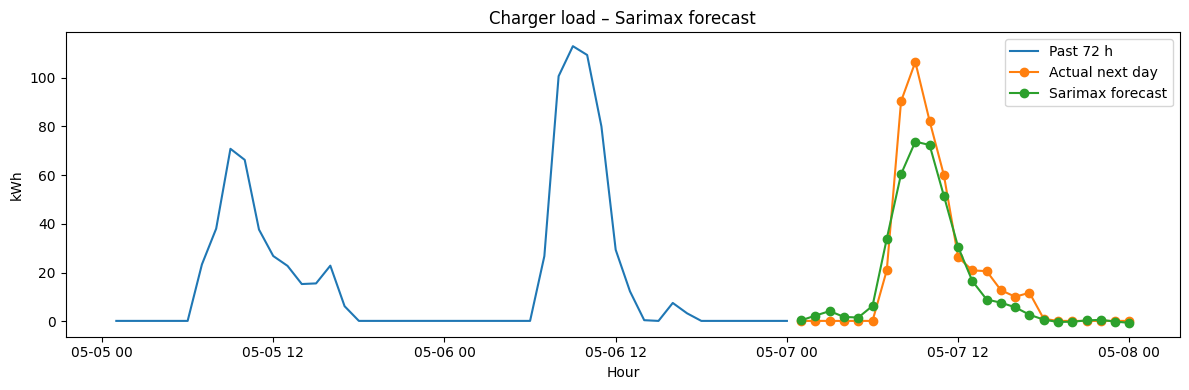

In [5]:
# ───────────────────────── IMPORTS ─────────────────────────
import math
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"
DAYS_TRAIN   = 175    # train on last 30 days
HRS_PER_DAY  = 24
LOOK_BACK    = DAYS_TRAIN * HRS_PER_DAY  # 720
N_FORECAST   = 24      # 1-day ahead
AR_ORDER     = 24      # AR(24)
SHOW_HOURS   = 2 * HRS_PER_DAY  # 72 h

if __name__ == "__main__":

    # ---------- load & sanity-check ----------
    # assume df is already in memory, indexed by pd.DatetimeIndex
    needed = LOOK_BACK + N_FORECAST
    if len(df) < needed:
        raise ValueError(f"Need ≥ {needed} rows (got {len(df)})")

    # last 30 days for training, next 24h for test
    df_recent = df.iloc[-needed:]
    df_train  = df_recent.iloc[:LOOK_BACK]
    df_test   = df_recent.iloc[LOOK_BACK:]
    y_train   = df_train[TARGET_COL].astype(float)
    y_test    = df_test[TARGET_COL]

    # ---------- fit AR(24) ----------
    model = sm.tsa.SARIMAX(y_train, order=(AR_ORDER, 0, 0),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    res = model.fit(disp=False)

    # ---------- 24-step forecast ----------
    preds = res.forecast(steps=N_FORECAST)

    # ── **CRUCIAL**: align the forecast’s index to your test set ──
    preds.index = df_test.index

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"AR({AR_ORDER}) →  MAE = {mae:.2f}   RMSE = {rmse:.2f}   R² = {r2:.2f}")

    # ---------------- plot ---------------------
    hist_3d = df_train.iloc[-SHOW_HOURS:][TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(hist_3d.index, hist_3d.values,      label="Past 72 h")
    plt.plot(df_test.index,   y_test.values,     "-o", label="Actual next day")
    plt.plot(preds.index,     preds.values,      "-o", label="Sarimax forecast")

    plt.title("Charger load – Sarimax forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [162]:
"""
LSTM(1×32) baseline – train on the last 30 days, forecast the last 24 h
────────────────────────────────────────────────────────────────────────
• no extra calendar / holiday / EV features
• scales the 30-day window to [0,1], builds many (24→1) training pairs
• walk-forward generates a 24-step forecast
• prints MAE / RMSE / R2 vs. the real last-day values
• shows past-vs-forecast plot
"""

# ───────────────────────── IMPORTS ─────────────────────────
import math
from pathlib import Path
from datetime import timedelta
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ───────────────────────── CONFIG ──────────────────────────
TARGET_COL   = "Chargers"

DAYS_TRAIN   = 175    # train horizon
HRS_PER_DAY  = 24
LOOK_BACK    = DAYS_TRAIN * HRS_PER_DAY     # 30 × 24 = 720
N_FORECAST   = 24        # forecast 1 day ahead

SEQ_LEN      = 24       # how many lags the LSTM sees  (1 per hour)
LSTM_UNITS   = 64      # neurons in the LSTM layer
EPOCHS       = 75
BATCH_SIZE   = 16
SEED         = 42

# reproducibility
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ─────────────────────── MAIN ───────────────────────
if __name__ == "__main__":

    # ---------- load & sanity-check ----------
    # (assumes you already have df with a DateTimeIndex & “Chargers” col)
    needed_rows = LOOK_BACK + N_FORECAST
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows (got {len(df)})")
    
    df_less = df.iloc[:]

    # keep only the *last* 31 days (30 for training, 1 for test)
    df_recent = df_less.iloc[-needed_rows:]

    


    df_train = df_recent.iloc[:LOOK_BACK]          # 30 days
    df_test  = df_recent.iloc[LOOK_BACK:]          # final 24 h
    y_train  = df_train[TARGET_COL].values.reshape(-1, 1)
    y_test   = df_test[TARGET_COL].values.reshape(-1, 1)

    # ---------- scaling ----------
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train).flatten()

    # ---------- build (X,y) pairs ----------
    X, y = [], []
    for i in range(len(y_train_scaled) - SEQ_LEN):
        X.append(y_train_scaled[i : i + SEQ_LEN])
        y.append(y_train_scaled[i + SEQ_LEN])
    X = np.array(X).reshape(-1, SEQ_LEN, 1)   # (samples, timesteps, features)
    y = np.array(y)

    # ---------- define & fit LSTM ----------
    model = Sequential([
        LSTM(LSTM_UNITS, input_shape=(SEQ_LEN, 1)),
        Dense(1, activation="linear")
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

    # ---------- 24-step walk-forward forecast ----------
    last_seq = y_train_scaled[-SEQ_LEN:].tolist()    # start-state (scaled)
    preds_scaled = []
    for _ in range(N_FORECAST):
        x_input = np.array(last_seq[-SEQ_LEN:]).reshape(1, SEQ_LEN, 1)
        next_val = model.predict(x_input, verbose=0)[0, 0]
        preds_scaled.append(next_val)
        last_seq.append(next_val)

    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

    # ---------- evaluation ----------
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"LSTM(1×{LSTM_UNITS}) →  MAE = {mae:6.2f}   RMSE = {rmse:6.2f}   R2 = {r2:6.2f}")

    # ---------------- plot (3-day window) ----------------
    hrs_history = 2 * 24                 # 72 h
    hist_3d = df_recent.iloc[-(hrs_history + N_FORECAST):-N_FORECAST]   # last 3 days

    plt.figure(figsize=(12, 4))
    plt.plot(hist_3d.index, hist_3d[TARGET_COL], label="Past 72 h")
    plt.plot(df_test.index, y_test.flatten(), "-o", label="Actual day-31")
    plt.plot(df_test.index, preds, "-o", label="LSTM forecast")
    plt.title("Charger load – LSTM forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    plt.legend(); plt.tight_layout(); plt.show()



c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

C:\Users\user\AppData\Local\Temp\ipykernel_20128\2212643125.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent["lag_24"] = df_recent[TARGET_COL].shift(24)
C:\Users\user\AppData\Local\Temp\ipykernel_20128\2212643125.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent["weekday_avg"] = df_recent.index.dayofweek.map(dow_mean)


LightGBM (+lag24 +weekday_avg) → MAE   6.39  RMSE  10.88  R²   0.66


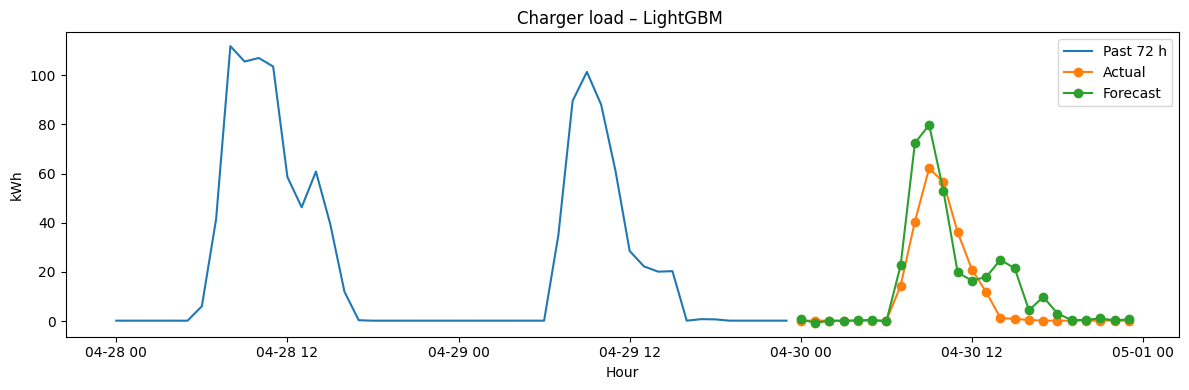

In [58]:
# ───────────── imports
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt, lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

LGB_PARAMS = dict(
    n_estimators      = 3000,
    learning_rate     = 0.05,
    num_leaves        = 128,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = "regression_l2",
    min_child_samples = 20,
    lambda_l1         = 0.1,
    lambda_l2         = 0.2,
    random_state      = 42,
    verbosity         = -1
)

# ───────────── helpers
def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    feats = pd.DataFrame(index=idx)
    feats["hour"], feats["dow"], feats["month"] = idx.hour, idx.dayofweek, idx.month
    feats["hour_sin"] = np.sin(2*np.pi*feats.hour/23);  feats["hour_cos"] = np.cos(2*np.pi*feats.hour/23)
    feats["dow_sin"]  = np.sin(2*np.pi*feats.dow/6);   feats["dow_cos"]  = np.cos(2*np.pi*feats.dow/6)
    return feats

# ───────────── main
if __name__ == "__main__":
    needed_rows = LOOK_BACK + N_FORECAST + 24          # +24 for lag feature
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")

    df_recent = df.iloc[-needed_rows:]
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(24)

    df_train_raw = df_recent.iloc[:-N_FORECAST]
    dow_mean = df_train_raw.groupby(df_train_raw.index.dayofweek)[TARGET_COL].mean()
    df_recent["weekday_avg"] = df_recent.index.dayofweek.map(dow_mean)

    df_recent = df_recent.dropna(subset=["lag_24", "weekday_avg"])
    split_pt  = len(df_recent) - N_FORECAST
    df_train, df_test = df_recent.iloc[:split_pt], df_recent.iloc[split_pt:]

    def build(frame):
        return make_calendar_features(frame.index).join(frame[["lag_24","weekday_avg"]])

    X_train, y_train = build(df_train), df_train[TARGET_COL]
    X_test,  y_test  = build(df_test),  df_test[TARGET_COL]

    # ────────── LightGBM fit (no “verbose=” argument)
    gbm = lgb.LGBMRegressor(**LGB_PARAMS)
    gbm.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l2",
        
        callbacks=[lgb.log_evaluation(period=0)]   # silences native logs
    )

    preds = gbm.predict(X_test)

    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"LightGBM (+lag24 +weekday_avg) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ────────── plot
    hrs_hist = 48
    hist = df_recent.iloc[-(hrs_hist+N_FORECAST):-N_FORECAST]
    plt.figure(figsize=(12,4))
    plt.plot(hist.index, hist[TARGET_COL], label="Past 72 h")
    plt.plot(y_test.index, y_test, "-o", label="Actual")
    plt.plot(y_test.index, preds, "-o", label="Forecast")
    plt.title("Charger load – LightGBM ")
    plt.xlabel("Hour");  plt.ylabel("kWh");  plt.legend();  plt.tight_layout();  plt.show()

   


LightGBM (lag-24 only) → MAE   4.45  RMSE   6.33  R²   0.88


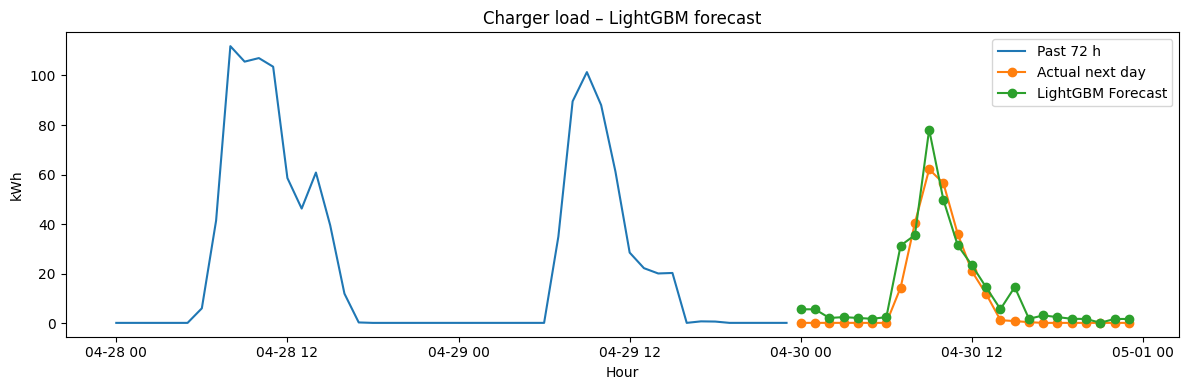

In [106]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175 , 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

LGB_PARAMS = dict(
    n_estimators      = 3000,
    learning_rate     = 0.05,
    num_leaves        = 128,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = "regression_l2",
    min_child_samples = 20,
    lambda_l1         = 0.1,
    lambda_l2         = 0.2,
    random_state      = 42,
    verbosity         = -1
)

if __name__ == "__main__":

    # ---- need enough data for 24-h lag + train + test
    needed_rows = LOOK_BACK + N_FORECAST + HRS_PER_DAY
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")
    
    df_less = df.iloc[:]

    # ---- take the last block, then build only the 24-h lag
    df_recent = df_less.iloc[-needed_rows:].copy()
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(HRS_PER_DAY)
    df_recent["day_of_week"] = df_recent.index.dayofweek

    

    # ---- calculate weekday average ----
    weekday_avg = df_recent.groupby('day_of_week')[TARGET_COL].transform('mean')
    df_recent["weekday_avg"] = weekday_avg

    # drop the first 24h (where lag is NaN)
    df_recent = df_recent.dropna(subset=["lag_24"])

    # split into train vs. test
    split_pt     = len(df_recent) - N_FORECAST
    df_train     = df_recent.iloc[:split_pt]
    df_test      = df_recent.iloc[split_pt:]
    X_train, y_train = df_train[["lag_24"]], df_train[TARGET_COL]
    X_test,  y_test  = df_test[ ["lag_24"]], df_test[ TARGET_COL]

    # ---- fit LightGBM on the single lag feature ----
    gbm = lgb.LGBMRegressor(**LGB_PARAMS)
    gbm.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l2",
        callbacks=[lgb.log_evaluation(period=0)]
    )

    # ---- predict and evaluate ----
    preds = gbm.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"LightGBM (lag-24 only) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot last 72h history + 24h forecast ----
    hrs_hist = 2 * HRS_PER_DAY
    hist     = df_recent.iloc[-(hrs_hist + N_FORECAST):-N_FORECAST][TARGET_COL]

    plt.figure(figsize=(12,4))
    plt.plot(hist.index,     hist,    label="Past 72 h")
    plt.plot(y_test.index,   y_test,  "-o", label="Actual next day")
    plt.plot(y_test.index,   preds,   "-o", label="LightGBM Forecast")
    plt.title("Charger load – LightGBM forecast")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    plt.legend(); plt.tight_layout(); plt.show()


CatBoost (lag-24 + weekday) → MAE   7.75  RMSE  13.19  R²   0.83


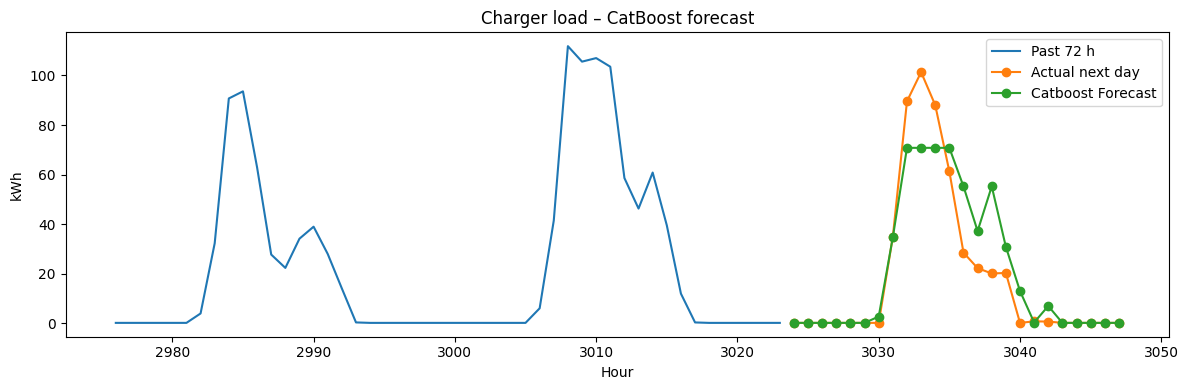

In [ ]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

CATBOOST_PARAMS = dict(
    iterations        = 3000,
    learning_rate     = 0.05,
    depth             = 6,
    subsample         = 0.8,
    colsample_bylevel = 0.8,
    loss_function     = "MAE",
    l2_leaf_reg       = 3,
    random_seed       = 42,
    verbose           = False
)

if __name__ == "__main__":

    # ---- check required rows ----
    needed_rows = LOOK_BACK + N_FORECAST + HRS_PER_DAY
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")

    df_less = df.iloc[:]

    # ---- last block & lag ----
    df_recent = df_less.iloc[-needed_rows:].copy()
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(HRS_PER_DAY)
    df_recent["day_of_week"] = df_recent.index.dayofweek

    

    # ---- calculate weekday average ----
    weekday_avg = df_recent.groupby('day_of_week')[TARGET_COL].transform('mean')
    df_recent["weekday_avg"] = weekday_avg

    # ---- remove weekends ----
    df_recent = df_recent[df_recent["day_of_week"] < 5].reset_index(drop=True)
    

    df_recent = df_recent.dropna(subset=["lag_24"])

    # ---- split train/test ----
    split_pt = len(df_recent) - N_FORECAST
    df_train = df_recent.iloc[:split_pt]
    df_test = df_recent.iloc[split_pt:]
    X_train, y_train = df_train[["lag_24", "day_of_week"]], df_train[TARGET_COL]
    X_test, y_test = df_test[["lag_24", "day_of_week"]], df_test[TARGET_COL]

    # ---- fit CatBoost ----
    cbr = CatBoostRegressor(**CATBOOST_PARAMS)
    cbr.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

    # ---- predict and evaluate ----
    preds = cbr.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"CatBoost (lag-24 + weekday) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot ----
    hrs_hist = 2 * HRS_PER_DAY
    hist = df_recent.iloc[-(hrs_hist + N_FORECAST):-N_FORECAST][TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(hist.index, hist, label="Past 72 h")
    plt.plot(y_test.index, y_test, "-o", label="Actual next day")
    plt.plot(y_test.index, preds, "-o", label="Catboost Forecast")
    plt.title("Charger load – CatBoost forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


[0]	validation_0-mae:9.63907
[1]	validation_0-mae:9.14869
[2]	validation_0-mae:9.14870
[3]	validation_0-mae:9.14871
[4]	validation_0-mae:8.58589
[5]	validation_0-mae:8.03835
[6]	validation_0-mae:7.55270
[7]	validation_0-mae:7.14342
[8]	validation_0-mae:7.14343
[9]	validation_0-mae:7.14345
[10]	validation_0-mae:6.67594
[11]	validation_0-mae:6.35039
[12]	validation_0-mae:5.99841
[13]	validation_0-mae:5.58989
[14]	validation_0-mae:5.58989
[15]	validation_0-mae:5.32745
[16]	validation_0-mae:5.32746
[17]	validation_0-mae:4.98058
[18]	validation_0-mae:4.71042
[19]	validation_0-mae:4.44937
[20]	validation_0-mae:4.23213
[21]	validation_0-mae:4.00730
[22]	validation_0-mae:3.79261
[23]	validation_0-mae:3.68776
[24]	validation_0-mae:3.68777
[25]	validation_0-mae:3.58058
[26]	validation_0-mae:3.44783
[27]	validation_0-mae:3.44784
[28]	validation_0-mae:3.32710
[29]	validation_0-mae:3.22261
[30]	validation_0-mae:3.16858
[31]	validation_0-mae:3.16858
[32]	validation_0-mae:3.16858
[33]	validation_0-ma

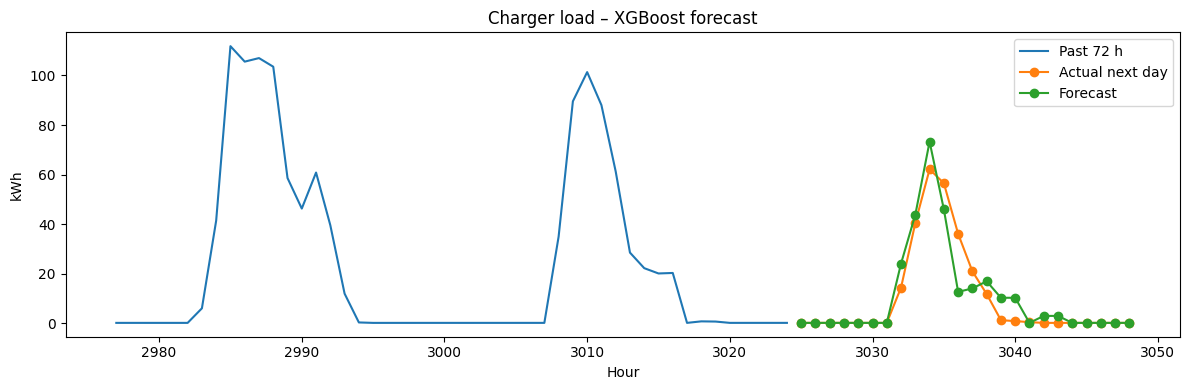

In [157]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

XGB_PARAMS = dict(
    n_estimators      = 3000,
    learning_rate     = 0.05,
    max_depth         = 6,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = "reg:absoluteerror",
    reg_lambda        = 3,
    random_state      = 42,
    verbosity         = 0
)

if __name__ == "__main__":

    # ---- check required rows ----
    needed_rows = LOOK_BACK + N_FORECAST + HRS_PER_DAY
    if len(df) < needed_rows:
        raise ValueError(f"Need ≥ {needed_rows} rows, got {len(df)}")

    df_less = df.iloc[:]

    # ---- last block & lag ----
    df_recent = df_less.iloc[-needed_rows:].copy()
    df_recent["lag_24"] = df_recent[TARGET_COL].shift(HRS_PER_DAY)
    df_recent["day_of_week"] = df_recent.index.dayofweek

    # ---- calculate weekday average ----
    weekday_avg = df_recent.groupby('day_of_week')[TARGET_COL].transform('mean')
    df_recent["weekday_avg"] = weekday_avg

    # ---- remove weekends ----
    df_recent = df_recent[df_recent["day_of_week"] < 5].reset_index(drop=True)

    df_recent = df_recent.dropna(subset=["lag_24"])

    # ---- split train/test ----
    split_pt = len(df_recent) - N_FORECAST
    df_train = df_recent.iloc[:split_pt]
    df_test = df_recent.iloc[split_pt:]
    X_train, y_train = df_train[["lag_24", "day_of_week", "weekday_avg"]], df_train[TARGET_COL]
    X_test, y_test = df_test[["lag_24", "day_of_week", "weekday_avg"]], df_test[TARGET_COL]

    # ---- fit XGBoost ----
    xgbr = xgb.XGBRegressor(**XGB_PARAMS)
    xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # ---- predict and evaluate ----
    preds = xgbr.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = math.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"XGBoost (lag-24 + weekday + weekday_avg) → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot ----
    hrs_hist = 2 * HRS_PER_DAY
    hist = df_recent.iloc[-(hrs_hist + N_FORECAST):-N_FORECAST][TARGET_COL]

    plt.figure(figsize=(12, 4))
    plt.plot(hist.index, hist, label="Past 72 h")
    plt.plot(y_test.index, y_test, "-o", label="Actual next day")
    plt.plot(y_test.index, preds, "-o", label="Forecast")
    plt.title("Charger load – XGBoost forecast")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


17:00:32 - cmdstanpy - INFO - Chain [1] start processing
17:00:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet → MAE  10.59  RMSE  21.32  R² -124051671.81


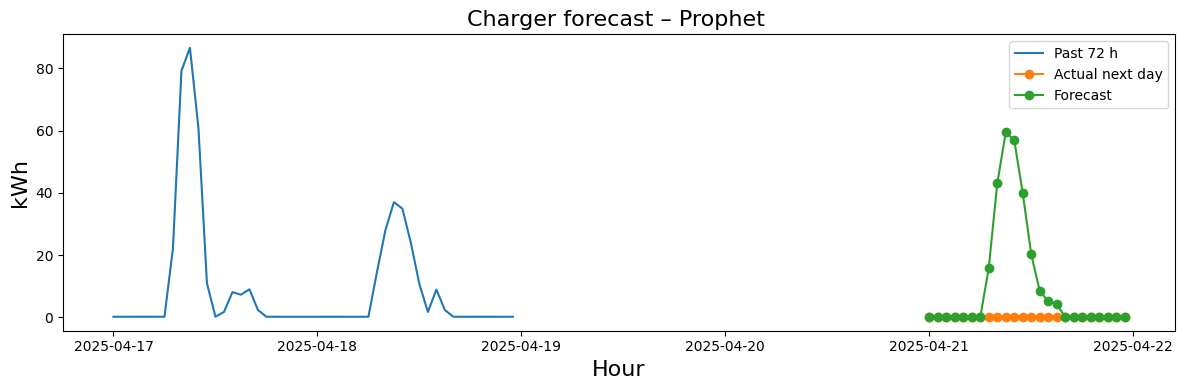

In [23]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ───────────── config
TARGET_COL, DAYS_TRAIN, HRS_PER_DAY = "Chargers", 175, 24
LOOK_BACK, N_FORECAST = DAYS_TRAIN * HRS_PER_DAY, 24

if __name__ == "__main__":

    df_less = df.iloc[:-216]

    # ---- ensure proper Prophet dataframe ----
    df_recent = df_less.iloc[-(LOOK_BACK + N_FORECAST):].copy().reset_index()
    df_recent.rename(columns={df_recent.columns[0]: 'ds', TARGET_COL: 'y'}, inplace=True)

    # Ensure 'ds' is datetime type explicitly
    df_recent['ds'] = pd.to_datetime(df_recent['ds'])

    # ---- remove weekends ----
    df_recent = df_recent[df_recent['ds'].dt.dayofweek < 5].reset_index(drop=True)

    # ---- split train/test ----
    df_train = df_recent.iloc[:-N_FORECAST]
    df_test = df_recent.iloc[-N_FORECAST:]

    # ---- fit Prophet ----
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.add_seasonality(name='hourly', period=24, fourier_order=12)
    model.fit(df_train[['ds', 'y']])

    # ---- create forecast dataframe ----
    future = model.make_future_dataframe(periods=N_FORECAST*2, freq='H')
    future = future[future['ds'].dt.dayofweek < 5].reset_index(drop=True)
    future = future.iloc[:len(df_train) + N_FORECAST]

    forecast = model.predict(future)
    preds = forecast.iloc[-N_FORECAST:]['yhat'].clip(lower=0).values

    # ---- evaluate predictions ----
    mae = mean_absolute_error(df_test['y'], preds)
    rmse = math.sqrt(mean_squared_error(df_test['y'], preds))
    r2 = r2_score(df_test['y'], preds)
    print(f"Prophet → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # ---- plot without weekends ----
    plt.figure(figsize=(12, 4))

    recent_history = df_train[df_train['ds'].dt.dayofweek < 5].iloc[-(2*HRS_PER_DAY):]

    plt.plot(recent_history['ds'], recent_history['y'], label="Past 72 h")
    plt.plot(df_test['ds'], df_test['y'], "-o", label="Actual next day")
    plt.plot(df_test['ds'], preds, "-o", label="Forecast")

    plt.title("Charger forecast – Prophet ", fontsize=16)
    plt.xlabel("Hour", fontsize=16)
    plt.ylabel("kWh", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()


14:48:33 - cmdstanpy - INFO - Chain [1] start processing
14:48:34 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-20 → MAE=6.64, Norm-MAE=0.299, R²=0.87, MAPE=350.48% (raw R²=0.87)


14:48:34 - cmdstanpy - INFO - Chain [1] start processing
14:48:34 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-21 → MAE=5.69, Norm-MAE=0.522, R²=0.72, MAPE=474.08% (raw R²=0.72)


14:48:35 - cmdstanpy - INFO - Chain [1] start processing
14:48:35 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-24 → MAE=7.10, Norm-MAE=0.417, R²=0.87, MAPE=933.63% (raw R²=0.87)


14:48:36 - cmdstanpy - INFO - Chain [1] start processing
14:48:36 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-25 → MAE=8.33, Norm-MAE=0.370, R²=0.81, MAPE=227.28% (raw R²=0.81)


14:48:36 - cmdstanpy - INFO - Chain [1] start processing
14:48:37 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-26 → MAE=3.91, Norm-MAE=0.211, R²=0.90, MAPE=62.61% (raw R²=0.90)


14:48:37 - cmdstanpy - INFO - Chain [1] start processing
14:48:37 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-27 → MAE=7.08, Norm-MAE=0.293, R²=0.87, MAPE=489.50% (raw R²=0.87)


14:48:38 - cmdstanpy - INFO - Chain [1] start processing
14:48:38 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-28 → MAE=3.82, Norm-MAE=0.222, R²=0.95, MAPE=287.12% (raw R²=0.95)


14:48:39 - cmdstanpy - INFO - Chain [1] start processing
14:48:39 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-03-31 → MAE=7.35, Norm-MAE=0.351, R²=0.83, MAPE=137.65% (raw R²=0.83)


14:48:39 - cmdstanpy - INFO - Chain [1] start processing
14:48:40 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-01 → MAE=5.63, Norm-MAE=0.375, R²=0.85, MAPE=1036.47% (raw R²=0.85)


14:48:40 - cmdstanpy - INFO - Chain [1] start processing
14:48:40 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-02 → MAE=10.51, Norm-MAE=1.556, R²=0.00, MAPE=1592.91% (raw R²=-0.38)


14:48:41 - cmdstanpy - INFO - Chain [1] start processing
14:48:41 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-03 → MAE=9.58, Norm-MAE=0.401, R²=0.83, MAPE=716.04% (raw R²=0.83)


14:48:42 - cmdstanpy - INFO - Chain [1] start processing
14:48:42 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-04 → MAE=7.62, Norm-MAE=1.458, R²=0.00, MAPE=1211.49% (raw R²=-1.59)


14:48:42 - cmdstanpy - INFO - Chain [1] start processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-07 → MAE=5.20, Norm-MAE=0.326, R²=0.91, MAPE=222.26% (raw R²=0.91)


14:48:43 - cmdstanpy - INFO - Chain [1] start processing
14:48:43 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-08 → MAE=7.40, Norm-MAE=0.404, R²=0.87, MAPE=1499.59% (raw R²=0.87)


14:48:44 - cmdstanpy - INFO - Chain [1] start processing
14:48:44 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-09 → MAE=6.48, Norm-MAE=0.521, R²=0.51, MAPE=519.97% (raw R²=0.51)


14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:45 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-10 → MAE=8.39, Norm-MAE=0.502, R²=0.84, MAPE=1293.54% (raw R²=0.84)


14:48:45 - cmdstanpy - INFO - Chain [1] start processing
14:48:46 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-11 → MAE=5.53, Norm-MAE=0.453, R²=0.76, MAPE=212.50% (raw R²=0.76)


14:48:46 - cmdstanpy - INFO - Chain [1] start processing
14:48:47 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-14 → MAE=5.36, Norm-MAE=0.426, R²=0.75, MAPE=374.81% (raw R²=0.75)


14:48:47 - cmdstanpy - INFO - Chain [1] start processing
14:48:47 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-15 → MAE=7.59, Norm-MAE=0.494, R²=0.84, MAPE=653.50% (raw R²=0.84)


14:48:48 - cmdstanpy - INFO - Chain [1] start processing
14:48:48 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-16 → MAE=4.81, Norm-MAE=0.468, R²=0.83, MAPE=1231.07% (raw R²=0.83)


14:48:50 - cmdstanpy - INFO - Chain [1] start processing
14:48:50 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-17 → MAE=10.17, Norm-MAE=0.841, R²=0.52, MAPE=1435.14% (raw R²=0.52)


14:48:51 - cmdstanpy - INFO - Chain [1] start processing
14:48:52 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-18 → MAE=4.17, Norm-MAE=0.609, R²=0.50, MAPE=96.52% (raw R²=0.50)


14:48:53 - cmdstanpy - INFO - Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-21 → MAE=0.00, Norm-MAE=nan, R²=1.00, MAPE=0.00% (raw R²=1.00)


14:48:55 - cmdstanpy - INFO - Chain [1] start processing
14:48:55 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-22 → MAE=15.56, Norm-MAE=0.497, R²=0.64, MAPE=171.39% (raw R²=0.64)


14:48:56 - cmdstanpy - INFO - Chain [1] start processing
14:48:57 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-23 → MAE=5.08, Norm-MAE=0.343, R²=0.85, MAPE=110.70% (raw R²=0.85)


14:48:58 - cmdstanpy - INFO - Chain [1] start processing
14:48:59 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-24 → MAE=5.10, Norm-MAE=0.296, R²=0.90, MAPE=132.59% (raw R²=0.90)


14:49:00 - cmdstanpy - INFO - Chain [1] start processing
14:49:01 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-25 → MAE=9.29, Norm-MAE=0.494, R²=0.64, MAPE=81.09% (raw R²=0.64)


14:49:02 - cmdstanpy - INFO - Chain [1] start processing
14:49:03 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-28 → MAE=15.49, Norm-MAE=0.535, R²=0.58, MAPE=77.28% (raw R²=0.58)


14:49:04 - cmdstanpy - INFO - Chain [1] start processing
14:49:05 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-29 → MAE=5.32, Norm-MAE=0.272, R²=0.92, MAPE=865.22% (raw R²=0.92)


14:49:06 - cmdstanpy - INFO - Chain [1] start processing
14:49:07 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-30 → MAE=2.48, Norm-MAE=0.241, R²=0.95, MAPE=174.32% (raw R²=0.95)


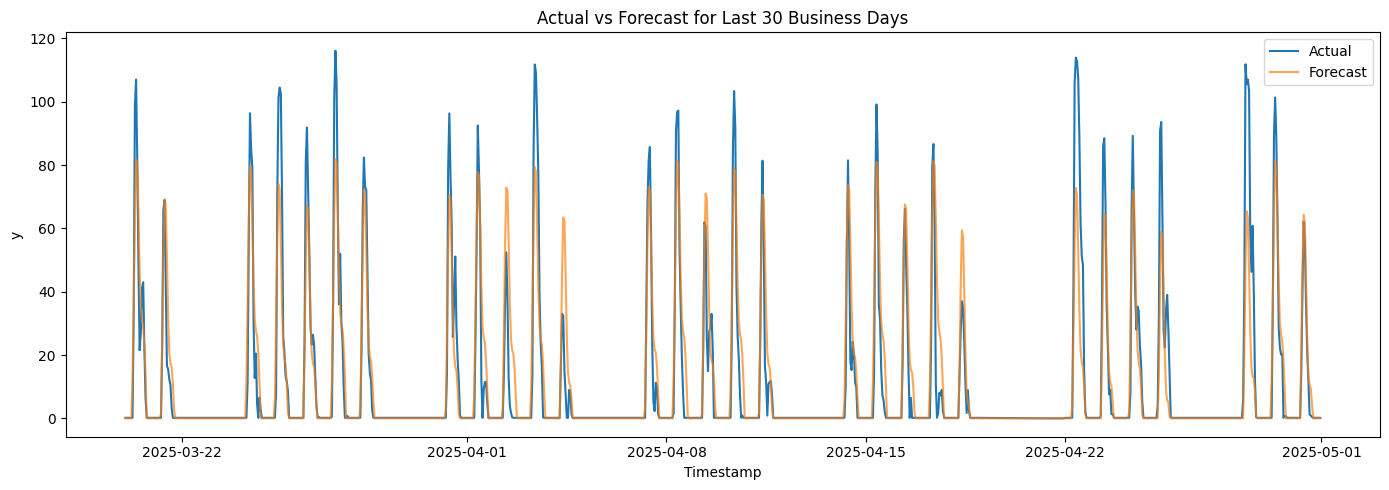

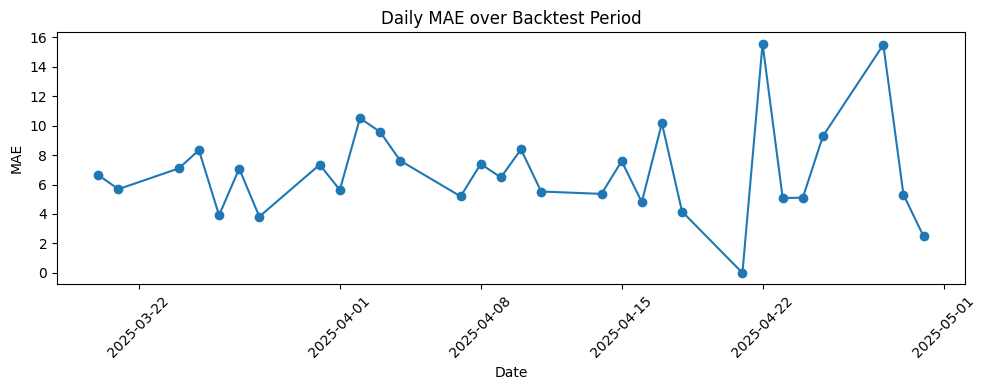

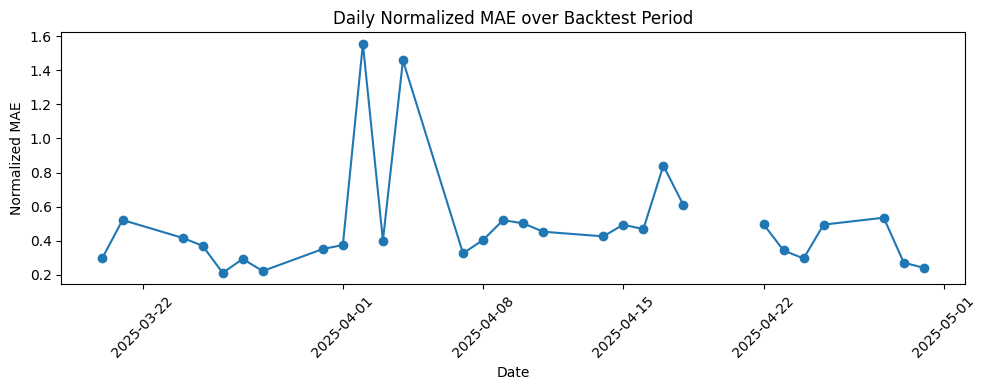

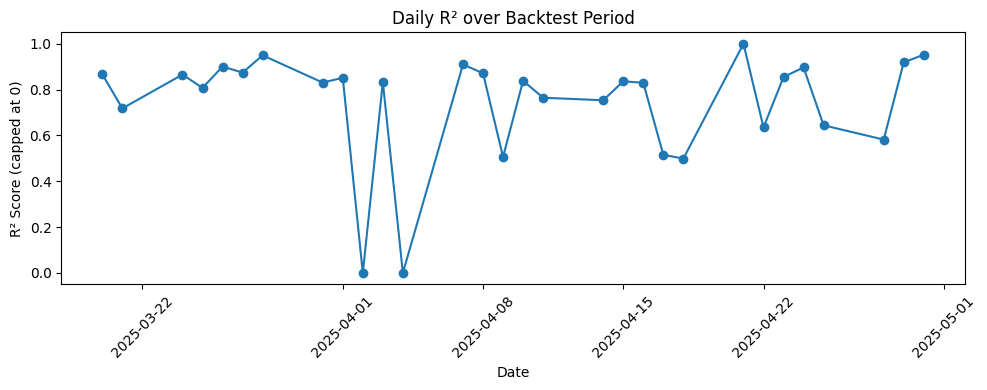

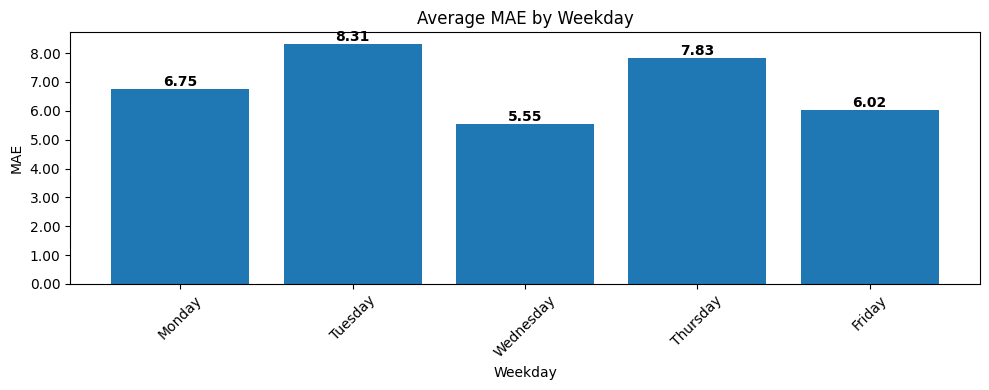

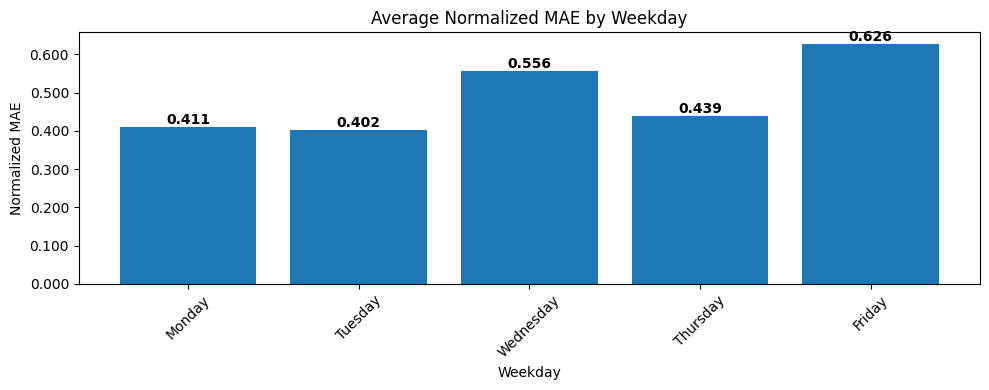

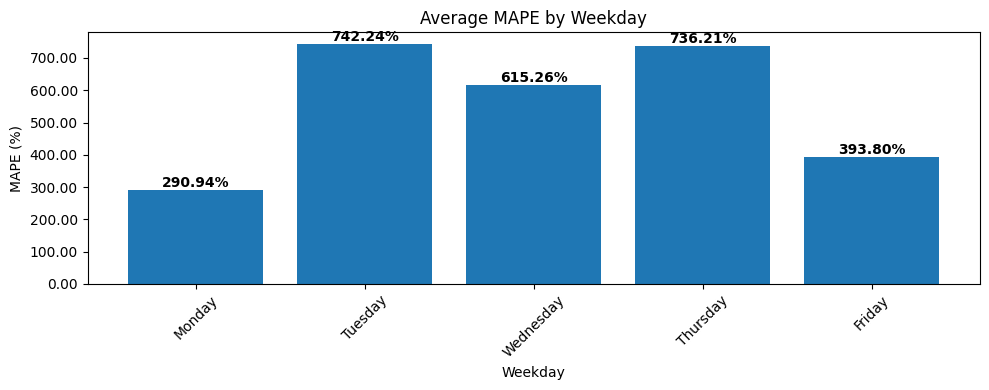

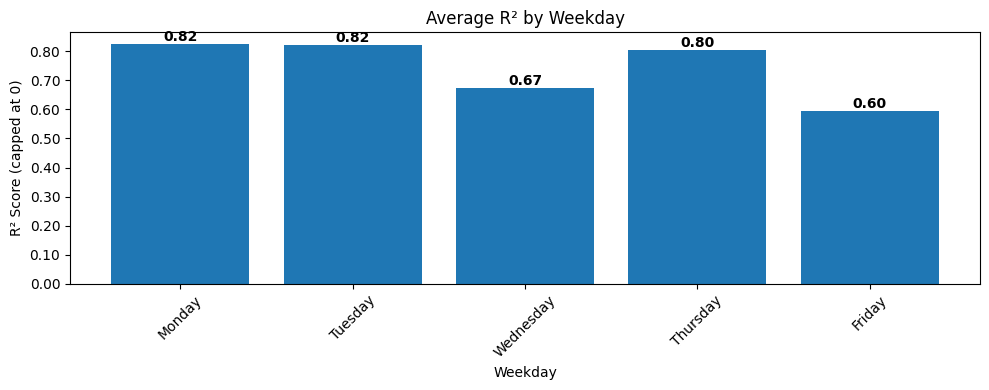

Overall Average MAE over 30 days: 6.89
Overall Average Normalized MAE over 30 days: 0.489
Overall Average MAPE over 30 days: 555.69%
Overall Average R² over 30 days: 0.74


In [19]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# ───────────── config
TARGET_COL = "Chargers"   # adjust to your actual column name if different
DAYS_TRAIN = 175         # days of history to train on
HRS_PER_DAY = 24
LOOK_BACK = DAYS_TRAIN * HRS_PER_DAY
FORECAST_DAYS = 30    # number of days to backtest
# Define specific holidays (dates formatted YYYY-MM-DD)
HOLIDAYS = [pd.to_datetime('2025-04-21').date()]


if __name__ == "__main__":
    # ----------------------------------------------------------------------------
    # Prepare DataFrame: bring timestamp into 'ds' and target into 'y'
    # ----------------------------------------------------------------------------
    df_all = df.copy()
    if isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.reset_index()
        df_all.rename(columns={df_all.columns[0]: 'ds'}, inplace=True)
    else:
        if df_all.columns[0] != 'ds':
            df_all.rename(columns={df_all.columns[0]: 'ds'}, inplace=True)
    df_all['ds'] = pd.to_datetime(df_all['ds'])

    data_cols = [c for c in df_all.columns if c != 'ds']
    if TARGET_COL in data_cols:
        source_col = TARGET_COL
    elif len(data_cols) == 1:
        source_col = data_cols[0]
        print(f"WARNING: TARGET_COL '{TARGET_COL}' not found. Using '{source_col}' as y.")
    else:
        raise KeyError(f"TARGET_COL '{TARGET_COL}' not found. Available: {data_cols}")
    df_all.rename(columns={source_col: 'y'}, inplace=True)

    # ----------------------------------------------------------------------------
    # Zero out consumption on holidays, remove weekends
    # ----------------------------------------------------------------------------
    df_all.loc[df_all['ds'].dt.date.isin(HOLIDAYS), 'y'] = 0
    df_all = df_all[df_all['ds'].dt.dayofweek < 5].reset_index(drop=True)

    df_less = df_all.iloc[:]

    # focus on last LOOK_BACK hours + backtest span
    total_hours = LOOK_BACK + FORECAST_DAYS * HRS_PER_DAY
    df_recent = df_less.iloc[-total_hours:].reset_index(drop=True)

    unique_days = np.sort(df_recent['ds'].dt.normalize().unique())
    forecast_days = unique_days[-FORECAST_DAYS:]

    # storage for results
    records = []

    for target_day in forecast_days:
        train_df = df_recent[df_recent['ds'] < target_day]
        test_mask = (
            (df_recent['ds'] >= target_day) &
            (df_recent['ds'] < target_day + pd.Timedelta(days=1))
        )
        test_df = df_recent[test_mask]

        # fit Prophet
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            changepoint_prior_scale=0.05
        )
        model.add_seasonality(name='hourly', period=24, fourier_order=12)
        model.fit(train_df[['ds', 'y']])

        # forecast
        future = test_df[['ds']].copy()
        forecast = model.predict(future)
        y_pred = forecast['yhat'].clip(lower=0).values

        # enforce night and holiday zeros
        hours = test_df['ds'].dt.hour.values
        night_mask = (hours >= 18) | (hours < 6)
        y_pred[night_mask] = 0
        if pd.to_datetime(target_day).date() in HOLIDAYS:
            y_pred[:] = 0

        y_true = test_df['y'].values

        # compute metrics
        mae = mean_absolute_error(y_true, y_pred)
        mean_true = y_true.mean() if y_true.mean() != 0 else np.nan
        nmae = mae / mean_true if mean_true else np.nan
        r2_raw = r2_score(y_true, y_pred)
        r2 = max(r2_raw, 0)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        # record per-hour and per-day stats
        for ds_val, actual, pred in zip(test_df['ds'], y_true, y_pred):
            records.append({
                'ds': ds_val,
                'actual': actual,
                'forecast': pred,
                'date': target_day,
                'day_mae': mae,
                'day_nmae': nmae,
                'day_r2': r2,
                'day_mape': mape
            })

        current_date = pd.to_datetime(target_day).date()
        print(
            f"Day {current_date} → "
            f"MAE={mae:.2f}, "
            f"Norm-MAE={nmae:.3f}, "
            f"R²={r2:.2f}, "
            f"MAPE={mape:.2f}% "
            f"(raw R²={r2_raw:.2f})"
        )

    # create results DataFrame
    results = pd.DataFrame(records)

    # ----------------------------------------------------------------------------
    # Plot 1: Actual vs Forecast across all backtest hours
    # ----------------------------------------------------------------------------
    plt.figure(figsize=(14, 5))
    plt.plot(results['ds'], results['actual'], label='Actual')
    plt.plot(results['ds'], results['forecast'], label='Forecast', alpha=0.7)
    plt.title(f"Actual vs Forecast for Last {FORECAST_DAYS} Business Days")
    plt.xlabel('Timestamp')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 2: Daily MAE
    # ----------------------------------------------------------------------------
    daily_err = (
        results[['date', 'day_mae']]
        .drop_duplicates()
        .sort_values('date')
    )
    plt.figure(figsize=(10, 4))
    plt.plot(daily_err['date'], daily_err['day_mae'], marker='o')
    plt.title('Daily MAE over Backtest Period')
    plt.xlabel('Date')
    plt.ylabel('MAE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 3: Daily Normalized MAE
    # ----------------------------------------------------------------------------
    daily_nmae = (
        results[['date', 'day_nmae']]
        .drop_duplicates()
        .sort_values('date')
    )
    plt.figure(figsize=(10, 4))
    plt.plot(daily_nmae['date'], daily_nmae['day_nmae'], marker='o')
    plt.title('Daily Normalized MAE over Backtest Period')
    plt.xlabel('Date')
    plt.ylabel('Normalized MAE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 4: Daily R²
    # ----------------------------------------------------------------------------
    daily_r2 = (
        results[['date', 'day_r2']]
        .drop_duplicates()
        .sort_values('date')
    )
    plt.figure(figsize=(10, 4))
    plt.plot(daily_r2['date'], daily_r2['day_r2'], marker='o')
    plt.title('Daily R² over Backtest Period')
    plt.xlabel('Date')
    plt.ylabel('R² Score (capped at 0)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 5: Average MAE by Weekday
    # ----------------------------------------------------------------------------
    daily_err['weekday'] = pd.to_datetime(daily_err['date']).dt.day_name()
    weekday_err = (
        daily_err
        .groupby('weekday')['day_mae']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_err.index, weekday_err.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}" for v in weekday_err.values],
        padding=0,
        color='black',
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average MAE by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('MAE')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 6: Average Normalized MAE by Weekday
    # ----------------------------------------------------------------------------
    daily_nmae['weekday'] = pd.to_datetime(daily_nmae['date']).dt.day_name()
    weekday_nmae = (
        daily_nmae
        .groupby('weekday')['day_nmae']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_nmae.index, weekday_nmae.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.3f}" for v in weekday_nmae.values],
        padding=0,
        color='black',
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average Normalized MAE by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('Normalized MAE')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 8: Average MAPE by Weekday
    # ----------------------------------------------------------------------------
    daily_mape = (
        results[['date', 'day_mape']]
        .drop_duplicates()
        .sort_values('date')
    )
    daily_mape['weekday'] = pd.to_datetime(daily_mape['date']).dt.day_name()
    weekday_mape = (
        daily_mape
        .groupby('weekday')['day_mape']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_mape.index, weekday_mape.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}%" for v in weekday_mape.values],
        padding=0,
        color='black',
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average MAPE by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('MAPE (%)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 7: Average R² by Weekday
    # ----------------------------------------------------------------------------
    daily_r2['weekday'] = pd.to_datetime(daily_r2['date']).dt.day_name()
    weekday_r2 = (
        daily_r2
        .groupby('weekday')['day_r2']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_r2.index, weekday_r2.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}" for v in weekday_r2.values],
        padding=0,
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average R² by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('R² Score (capped at 0)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



    # ----------------------------------------------------------------------------
    # Print Overall Averages
    # ----------------------------------------------------------------------------
    avg_mae   = daily_err['day_mae'].mean()
    avg_nmae  = daily_nmae['day_nmae'].mean()
    avg_r2    = daily_r2['day_r2'].mean()
    avg_mape  = daily_mape['day_mape'].mean()
    print(f"Overall Average MAE over {FORECAST_DAYS} days: {avg_mae:.2f}")
    print(f"Overall Average Normalized MAE over {FORECAST_DAYS} days: {avg_nmae:.3f}")
    print(f"Overall Average MAPE over {FORECAST_DAYS} days: {avg_mape:.2f}%")
    print(f"Overall Average R² over {FORECAST_DAYS} days: {avg_r2:.2f}")



18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:30 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-09 → MAE=5.25, Norm-MAE=0.422, R²=0.70, MAPE=384.89% (raw R²=0.70)


18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-10 → MAE=6.88, Norm-MAE=0.412, R²=0.88, MAPE=877.84% (raw R²=0.88)


18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-11 → MAE=4.17, Norm-MAE=0.342, R²=0.90, MAPE=235.51% (raw R²=0.90)


18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-12 → MAE=0.16, Norm-MAE=0.999, R²=0.00, MAPE=99.94% (raw R²=-3556.56)


18:25:41 - cmdstanpy - INFO - Chain [1] start processing
18:25:44 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-13 → MAE=0.64, Norm-MAE=4.056, R²=0.00, MAPE=408.29% (raw R²=-261310.83)


18:25:45 - cmdstanpy - INFO - Chain [1] start processing
18:25:48 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-14 → MAE=5.91, Norm-MAE=0.469, R²=0.64, MAPE=209.54% (raw R²=0.64)


18:25:50 - cmdstanpy - INFO - Chain [1] start processing
18:25:51 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-15 → MAE=5.86, Norm-MAE=0.381, R²=0.88, MAPE=316.64% (raw R²=0.88)


18:25:52 - cmdstanpy - INFO - Chain [1] start processing
18:25:55 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-16 → MAE=3.53, Norm-MAE=0.343, R²=0.90, MAPE=1131.11% (raw R²=0.90)


18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-17 → MAE=8.69, Norm-MAE=0.719, R²=0.54, MAPE=1145.09% (raw R²=0.54)


18:26:00 - cmdstanpy - INFO - Chain [1] start processing
18:26:02 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-18 → MAE=2.30, Norm-MAE=0.336, R²=0.78, MAPE=91.06% (raw R²=0.78)


18:26:03 - cmdstanpy - INFO - Chain [1] start processing
18:26:05 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-19 → MAE=0.16, Norm-MAE=1.000, R²=0.00, MAPE=100.00% (raw R²=-2985.64)


18:26:07 - cmdstanpy - INFO - Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-20 → MAE=0.16, Norm-MAE=1.000, R²=0.00, MAPE=100.00% (raw R²=-3918.94)


18:26:11 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-21 → MAE=0.16, Norm-MAE=1.000, R²=0.00, MAPE=100.00% (raw R²=-6594.20)


18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:18 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-22 → MAE=14.13, Norm-MAE=0.451, R²=0.71, MAPE=78.36% (raw R²=0.71)


18:26:19 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-23 → MAE=4.94, Norm-MAE=0.333, R²=0.88, MAPE=107.86% (raw R²=0.88)


18:26:22 - cmdstanpy - INFO - Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-24 → MAE=3.35, Norm-MAE=0.194, R²=0.95, MAPE=69.19% (raw R²=0.95)


18:26:26 - cmdstanpy - INFO - Chain [1] start processing
18:26:30 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-25 → MAE=10.20, Norm-MAE=0.543, R²=0.62, MAPE=83.05% (raw R²=0.62)


18:26:31 - cmdstanpy - INFO - Chain [1] start processing
18:26:34 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-26 → MAE=0.14, Norm-MAE=0.926, R²=0.00, MAPE=92.74% (raw R²=-2382.66)


18:26:35 - cmdstanpy - INFO - Chain [1] start processing
18:26:37 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-27 → MAE=0.16, Norm-MAE=1.000, R²=0.00, MAPE=100.00% (raw R²=-2968.70)


18:26:38 - cmdstanpy - INFO - Chain [1] start processing
18:26:40 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-28 → MAE=12.89, Norm-MAE=0.445, R²=0.71, MAPE=84.35% (raw R²=0.71)


18:26:41 - cmdstanpy - INFO - Chain [1] start processing
18:26:43 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-29 → MAE=4.58, Norm-MAE=0.234, R²=0.95, MAPE=542.39% (raw R²=0.95)


18:26:45 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-04-30 → MAE=2.42, Norm-MAE=0.235, R²=0.94, MAPE=160.19% (raw R²=0.94)


18:26:49 - cmdstanpy - INFO - Chain [1] start processing
18:26:51 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-01 → MAE=18.68, Norm-MAE=119.239, R²=0.00, MAPE=12048.26% (raw R²=-183482754.53)


18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:26:54 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-02 → MAE=6.89, Norm-MAE=1.716, R²=0.00, MAPE=1929.14% (raw R²=-0.37)


18:26:56 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-03 → MAE=0.19, Norm-MAE=1.204, R²=0.00, MAPE=120.29% (raw R²=-7328.23)


18:27:00 - cmdstanpy - INFO - Chain [1] start processing
18:27:02 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-04 → MAE=0.16, Norm-MAE=1.000, R²=0.00, MAPE=100.00% (raw R²=-15631.37)


18:27:03 - cmdstanpy - INFO - Chain [1] start processing
18:27:06 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-05 → MAE=5.48, Norm-MAE=0.378, R²=0.80, MAPE=75.93% (raw R²=0.80)


18:27:07 - cmdstanpy - INFO - Chain [1] start processing
18:27:10 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-06 → MAE=8.10, Norm-MAE=0.401, R²=0.86, MAPE=809.54% (raw R²=0.86)


18:27:11 - cmdstanpy - INFO - Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing


Day 2025-05-07 → MAE=6.14, Norm-MAE=0.317, R²=0.84, MAPE=68.20% (raw R²=0.84)


18:27:15 - cmdstanpy - INFO - Chain [1] start processing
18:27:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Day 2025-05-08 → MAE=0.16, Norm-MAE=1.000, R²=nan, MAPE=100.00% (raw R²=nan)
[BASE] 2025-04-09  MAE=5.28  N-MAE=0.424  R²=0.71  MAPE=355.05%  (raw R²=0.71)
[BASE] 2025-04-10  MAE=6.95  N-MAE=0.416  R²=0.88  MAPE=984.31%  (raw R²=0.88)
[BASE] 2025-04-11  MAE=4.22  N-MAE=0.346  R²=0.89  MAPE=208.62%  (raw R²=0.89)
[BASE] 2025-04-12  MAE=0.33  N-MAE=2.144  R²=0.00  MAPE=214.71%  (raw R²=-61536.00)
[BASE] 2025-04-13  MAE=0.16  N-MAE=1.006  R²=0.00  MAPE=100.98%  (raw R²=-23194.75)
[BASE] 2025-04-14  MAE=6.42  N-MAE=0.509  R²=0.61  MAPE=267.69%  (raw R²=0.61)
[BASE] 2025-04-15  MAE=5.78  N-MAE=0.376  R²=0.88  MAPE=304.83%  (raw R²=0.88)
[BASE] 2025-04-16  MAE=4.07  N-MAE=0.396  R²=0.87  MAPE=1273.23%  (raw R²=0.87)
[BASE] 2025-04-17  MAE=8.98  N-MAE=0.742  R²=0.54  MAPE=1276.05%  (raw R²=0.54)
[BASE] 2025-04-18  MAE=4.54  N-MAE=0.663  R²=0.54  MAPE=429.05%  (raw R²=0.54)
[BASE] 2025-04-19  MAE=0.33  N-MAE=2.141  R²=0.00  MAPE=215.88%  (raw R²=-51555.99)
[BASE] 2025-04-20  MAE=0.16  N-MAE=1.

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


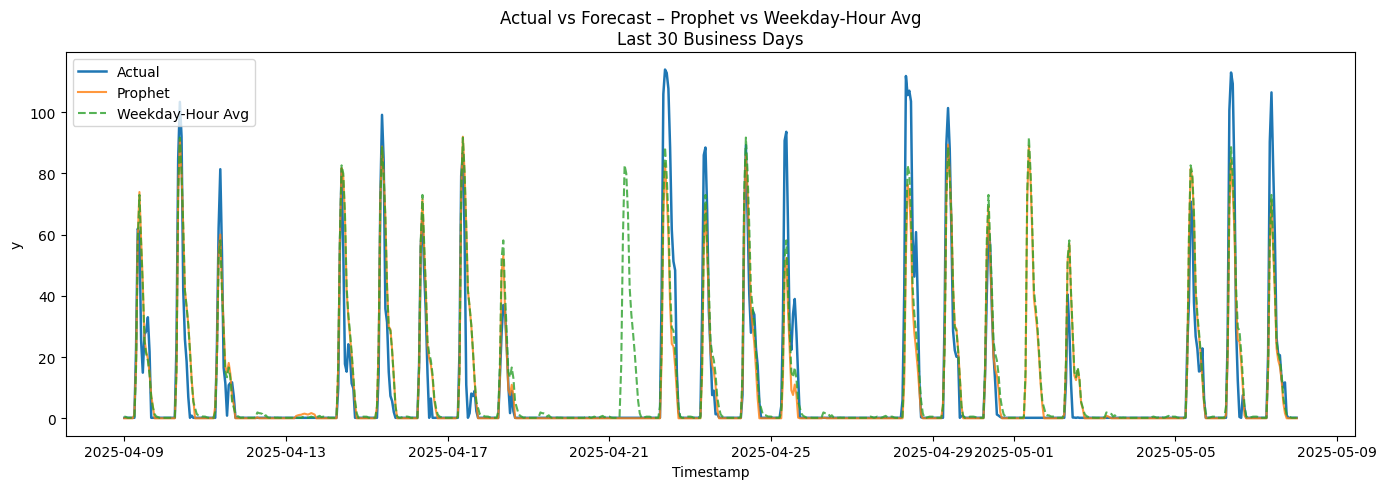


──────────────── OVERALL AVERAGES ────────────────
Prophet  – MAE  : 4.90
Baseline – MAE  : 5.58
Prophet  – R²   : 0.499
Baseline – R²   : 0.496
───────────────────────────────────────────────────


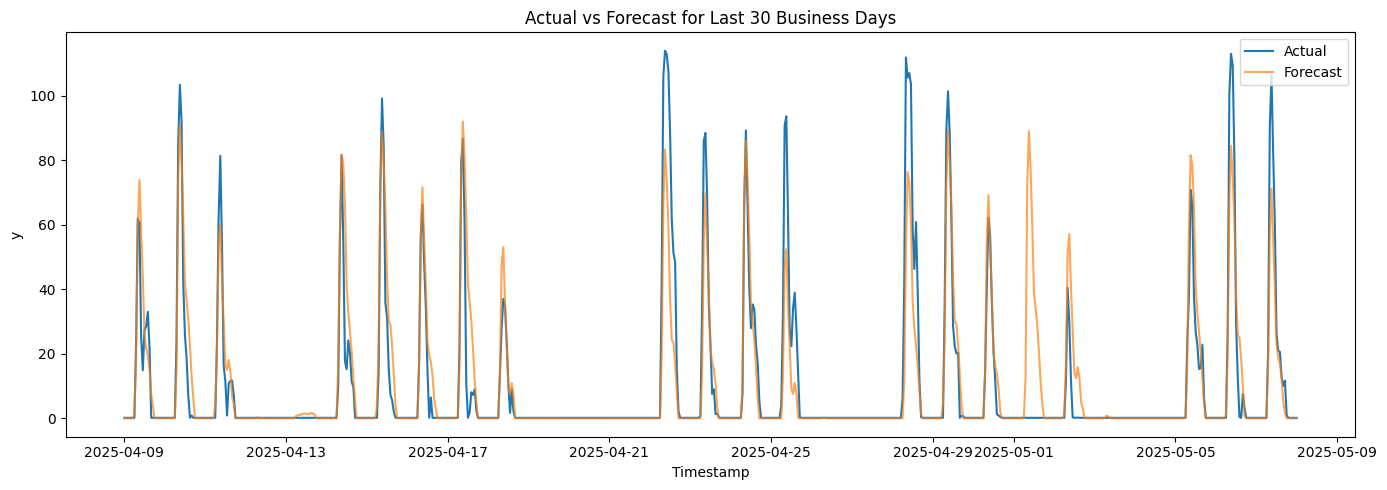

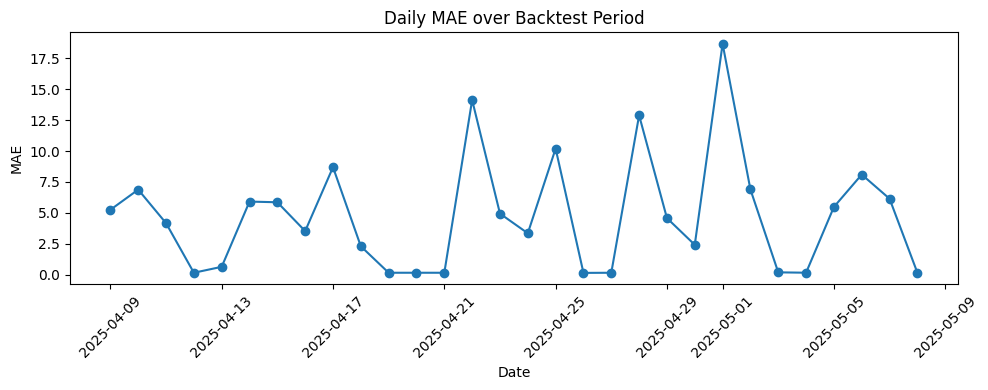

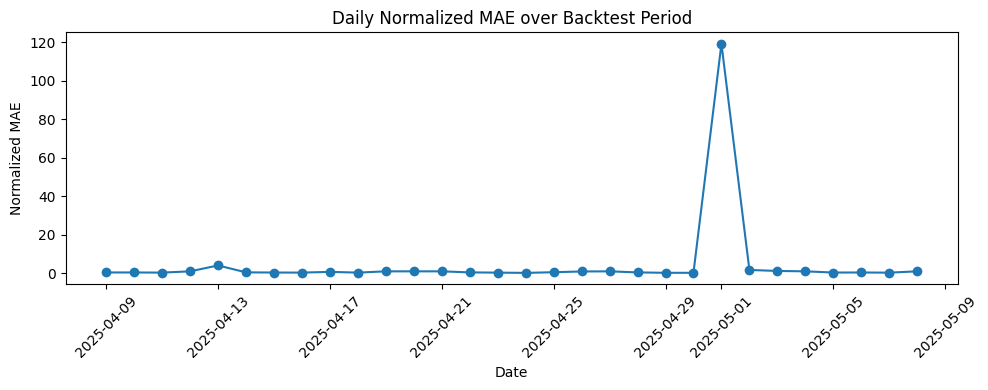

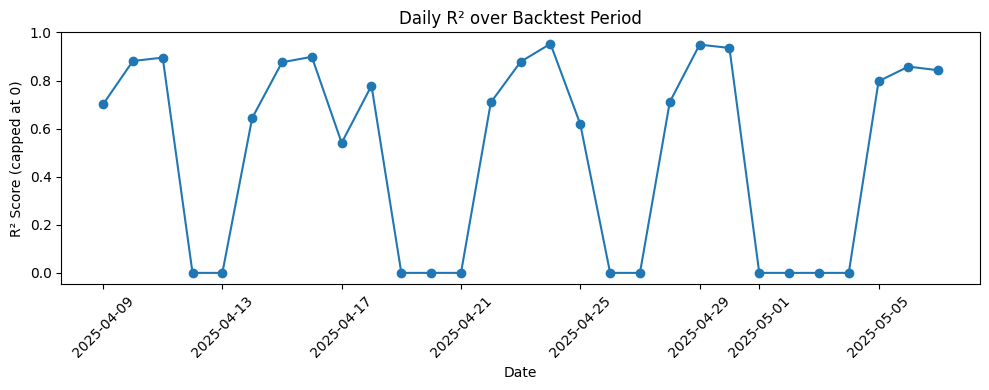

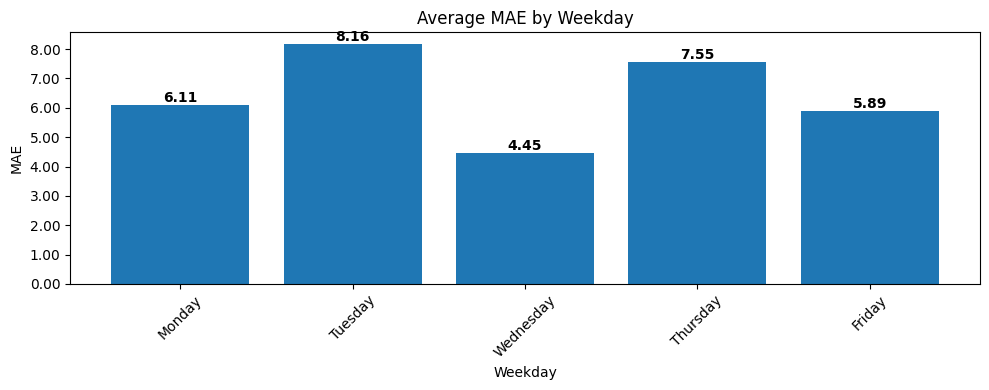

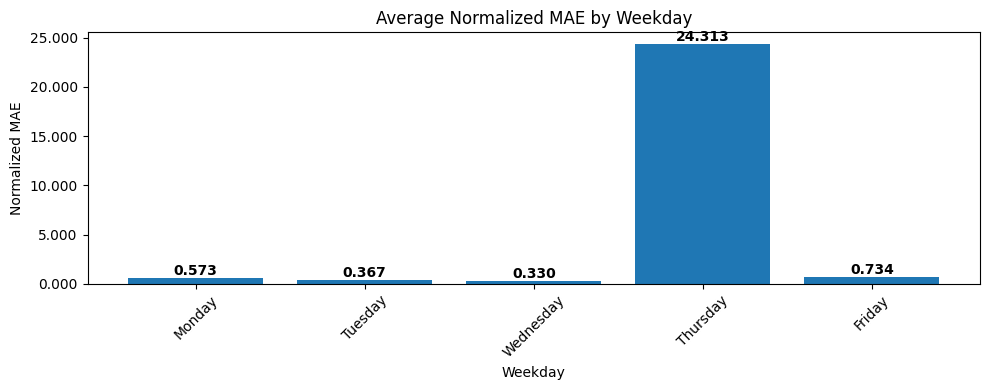

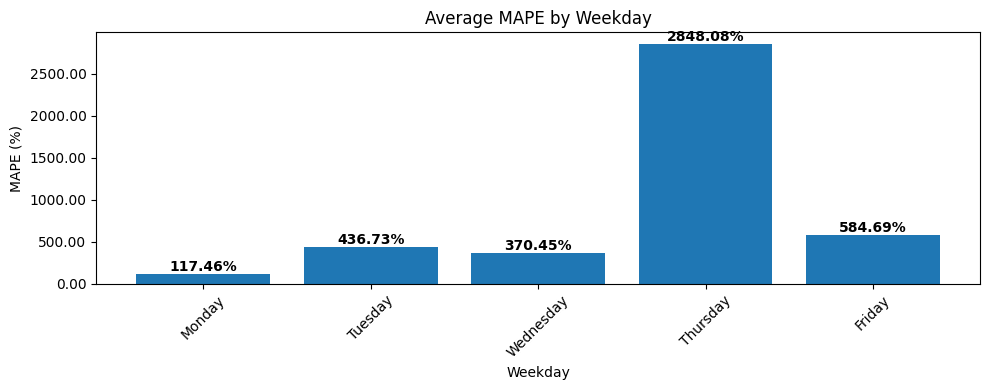

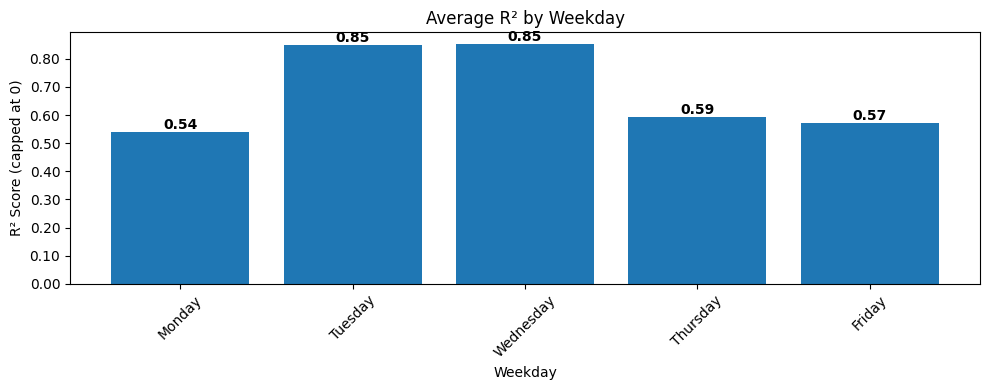

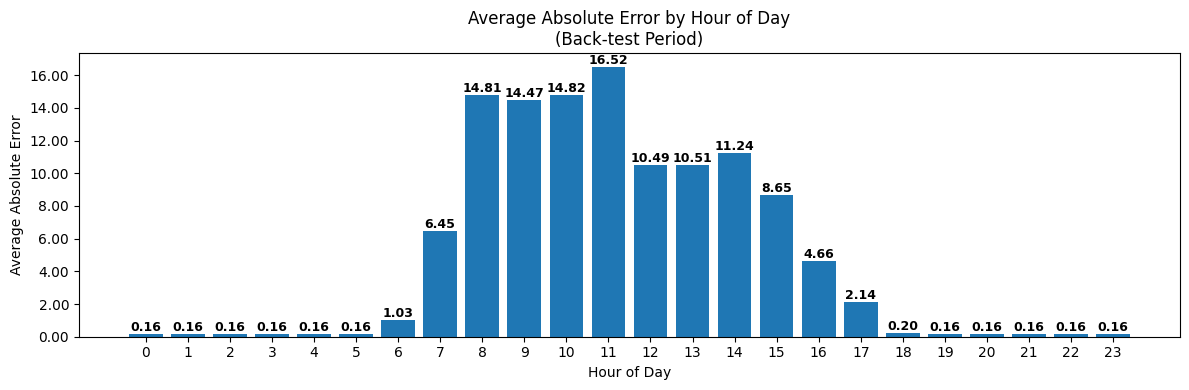

Overall Average MAE over 30 days: 4.75
Overall Average Normalized MAE over 30 days: 4.703
Overall Average MAPE over 30 days: 725.65%
Overall Average R² over 30 days: 0.50


In [7]:
# ───────────── imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# ───────────── config
TARGET_COL = "Chargers"   # adjust to your actual column name if different
DAYS_TRAIN = 200        # days of history to train on
HRS_PER_DAY = 24
LOOK_BACK = DAYS_TRAIN * HRS_PER_DAY
FORECAST_DAYS = 30   # number of days to backtest
# Define specific holidays (dates formatted YYYY-MM-DD)
HOLIDAYS = [pd.to_datetime('2025-04-21').date()]


if __name__ == "__main__":
    # ----------------------------------------------------------------------------
    # Prepare DataFrame: bring timestamp into 'ds' and target into 'y'
    # ----------------------------------------------------------------------------
    df_all = df.copy()
    if isinstance(df_all.index, pd.DatetimeIndex):
        df_all = df_all.reset_index()
        df_all.rename(columns={df_all.columns[0]: 'ds'}, inplace=True)
    else:
        if df_all.columns[0] != 'ds':
            df_all.rename(columns={df_all.columns[0]: 'ds'}, inplace=True)
    df_all['ds'] = pd.to_datetime(df_all['ds'])

    data_cols = [c for c in df_all.columns if c != 'ds']
    if TARGET_COL in data_cols:
        source_col = TARGET_COL
    elif len(data_cols) == 1:
        source_col = data_cols[0]
        print(f"WARNING: TARGET_COL '{TARGET_COL}' not found. Using '{source_col}' as y.")
    else:
        raise KeyError(f"TARGET_COL '{TARGET_COL}' not found. Available: {data_cols}")
    df_all.rename(columns={source_col: 'y'}, inplace=True)

    # ----------------------------------------------------------------------------
    # Zero out consumption on holidays, remove weekends
    # ----------------------------------------------------------------------------
    

    df_less = df_all.iloc[:]

    # focus on last LOOK_BACK hours + backtest span
    total_hours = LOOK_BACK + FORECAST_DAYS * HRS_PER_DAY
    df_recent = df_less.iloc[-total_hours:].reset_index(drop=True)

    unique_days = np.sort(df_recent['ds'].dt.normalize().unique())
    forecast_days = unique_days[-FORECAST_DAYS:]

    # ────────────── Weekday–Hour average lookup (train-only) ──────────────
    first_test_day = pd.to_datetime(forecast_days[0])          # earliest day in back-test
    hist_mask      = df_recent['ds'] < first_test_day          # avoid leakage
    hist           = df_recent[hist_mask].copy()

    hist['wkday']  = hist['ds'].dt.dayofweek                   # 0–4 (Mon–Fri)
    hist['hour']   = hist['ds'].dt.hour

    wkhr_avg_tbl = (
        hist.groupby(['wkday', 'hour'])['y']
            .mean()
            .unstack('hour')                                   # nice to inspect
    )


    # storage for results
    records = []

    for target_day in forecast_days:
        target_day = pd.to_datetime(target_day)                # cast once
        # ---------------- TRAIN / TEST SPLIT ----------------
        train_df = df_recent[df_recent['ds'] < target_day].copy()
        test_mask = (df_recent['ds'] >= target_day) & \
                    (df_recent['ds'] < target_day + pd.Timedelta(days=1))
        test_df  = df_recent[test_mask].copy()

        # ==== inject weekday–hour average as a regressor (no leakage) ====
        for df_ in (train_df, test_df):
            wk   = df_['ds'].dt.dayofweek
            hr   = df_['ds'].dt.hour
            df_['wdhr_avg'] = [wkhr_avg_tbl.loc[w, h] for w, h in zip(wk, hr)]
            df_['wk'] = wk

        # ---------------- FIT PROPHET ----------------
        model = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            changepoint_prior_scale=0.05
        )
        model.add_seasonality(name='hourly', period=24, fourier_order=12)
        model.add_regressor('wdhr_avg', standardize=False)      # <-- NEW
        model.add_regressor('wk', standardize=False)
        model.fit(train_df[['ds', 'y', 'wdhr_avg','wk']])

        # ---------------- FORECAST ----------------
        future   = test_df[['ds', 'wdhr_avg','wk']].copy()           # keep regressor
        forecast = model.predict(future)
        y_pred   = forecast['yhat'].clip(lower=0).values

        # enforce night and holiday zeros
        hours = test_df['ds'].dt.hour.values
        night_mask = (hours >= 18) | (hours < 6)
        y_pred[night_mask] = 0
        if pd.to_datetime(target_day).date() in HOLIDAYS:
            y_pred[:] = 0

        y_true = test_df['y'].values

        # compute metrics
        mae = mean_absolute_error(y_true, y_pred)
        mean_true = y_true.mean() if y_true.mean() != 0 else np.nan
        nmae = mae / mean_true if mean_true else np.nan
        r2_raw = r2_score(y_true, y_pred)
        r2 = max(r2_raw, 0)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        # record per-hour and per-day stats
        for ds_val, actual, pred in zip(test_df['ds'], y_true, y_pred):
            records.append({
                'ds': ds_val,
                'actual': actual,
                'forecast': pred,
                'date': target_day,
                'day_mae': mae,
                'day_nmae': nmae,
                'day_r2': r2,
                'day_mape': mape
            })

        current_date = pd.to_datetime(target_day).date()
        print(
            f"Day {current_date} → "
            f"MAE={mae:.2f}, "
            f"Norm-MAE={nmae:.3f}, "
            f"R²={r2:.2f}, "
            f"MAPE={mape:.2f}% "
            f"(raw R²={r2_raw:.2f})"
        )

    # create results DataFrame
    results = pd.DataFrame(records)

        # ════════════════════════════════════════════════════════════════════════════
    # WEEKDAY-HOUR AVERAGE BASELINE (Benchmark)
    # Add this AFTER the `results = pd.DataFrame(records)` line
    # ────────────────────────────────────────────────────────────────────────────
    # 1. Build lookup table:  weekday (0-4) × hour (0-23)  →  average y
    #    *Only* data strictly earlier than the first back-test day is used.
    # ════════════════════════════════════════════════════════════════════════════
    train_cutoff = forecast_days[0]                        # first day we back-test on
    train_hist   = df_recent[df_recent['ds'] < train_cutoff].copy()

    train_hist['wkday'] = train_hist['ds'].dt.dayofweek    # 0 = Monday … 4 = Friday
    train_hist['hour']  = train_hist['ds'].dt.hour
    wkhr_avg = (
        train_hist
        .groupby(['wkday', 'hour'])['y']
        .mean()
        .unstack('hour')                                   # nicer to look at
    )

    # ════════════════════════════════════════════════════════════════════════════
    # 2. Forecast every back-test day with the baseline
    # ════════════════════════════════════════════════════════════════════════════
    baseline_recs = []

    for target_day in forecast_days:
        target_day = pd.to_datetime(target_day)  
        test_mask  = (
            (df_recent['ds'] >= target_day) &
            (df_recent['ds'] < target_day + pd.Timedelta(days=1))
        )
        test_df    = df_recent[test_mask].copy()
        hrs        = test_df['ds'].dt.hour
        wkday_code = pd.to_datetime(target_day).weekday()   # 0-4
        
        # grab the pre-computed average for this weekday & hour
        test_df['baseline'] = [
            wkhr_avg.loc[wkday_code, h] for h in hrs
        ]
        
        
        
        # metrics
        y_true   = test_df['y'].values
        y_pred   = test_df['baseline'].values
        mae      = mean_absolute_error(y_true, y_pred)
        nmae     = mae / y_true.mean() if y_true.mean() else np.nan
        r2_raw   = r2_score(y_true, y_pred)
        r2       = max(r2_raw, 0)
        mape     = mean_absolute_percentage_error(y_true, y_pred) * 100
        
        for ds_val, actual, pred in zip(test_df['ds'], y_true, y_pred):
            baseline_recs.append({
                'ds':        ds_val,
                'actual':    actual,
                'baseline':  pred,
                'date':      target_day,
                'day_mae':   mae,
                'day_nmae':  nmae,
                'day_r2':    r2,
                'day_mape':  mape
            })
        
        print(
            f"[BASE] {target_day.date()}  "
            f"MAE={mae:.2f}  N-MAE={nmae:.3f}  R²={r2:.2f}  MAPE={mape:.2f}%"
            f"  (raw R²={r2_raw:.2f})"
        )

    baseline_results = pd.DataFrame(baseline_recs)

    # ════════════════════════════════════════════════════════════════════════════
    # 3. Quick visual comparison – overlay Prophet vs baseline
    # ════════════════════════════════════════════════════════════════════════════
    plt.figure(figsize=(14, 5))
    plt.plot(results['ds'], results['actual'],   label='Actual',   linewidth=1.8)
    plt.plot(results['ds'], results['forecast'], label='Prophet',  alpha=0.8)
    plt.plot(baseline_results['ds'], baseline_results['baseline'],
            label='Weekday-Hour Avg', alpha=0.8, linestyle='--')
    plt.title(f"Actual vs Forecast – Prophet vs Weekday-Hour Avg\n"
            f"Last {FORECAST_DAYS} Business Days")
    plt.xlabel('Timestamp')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ════════════════════════════════════════════════════════════════════════════
    # 4. Overall metric summary
    # ════════════════════════════════════════════════════════════════════════════
    def _overall(df, col):        # small helper
        return df[col].mean()

    print("\n──────────────── OVERALL AVERAGES ────────────────")
    print(f"Prophet  – MAE  : {_overall(results,  'day_mae') :.2f}")
    print(f"Baseline – MAE  : {_overall(baseline_results, 'day_mae') :.2f}")
    print(f"Prophet  – R²   : {_overall(results,  'day_r2')  :.3f}")
    print(f"Baseline – R²   : {_overall(baseline_results, 'day_r2')  :.3f}")
    print("───────────────────────────────────────────────────")
    # ════════════════════════════════════════════════════════════════════════════


    # ----------------------------------------------------------------------------
    # Plot 1: Actual vs Forecast across all backtest hours
    # ----------------------------------------------------------------------------
    plt.figure(figsize=(14, 5))
    plt.plot(results['ds'], results['actual'], label='Actual')
    plt.plot(results['ds'], results['forecast'], label='Forecast', alpha=0.7)
    plt.title(f"Actual vs Forecast for Last {FORECAST_DAYS} Business Days")
    plt.xlabel('Timestamp')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 2: Daily MAE
    # ----------------------------------------------------------------------------
    daily_err = (
        results[['date', 'day_mae']]
        .drop_duplicates()
        .sort_values('date')
    )
    plt.figure(figsize=(10, 4))
    plt.plot(daily_err['date'], daily_err['day_mae'], marker='o')
    plt.title('Daily MAE over Backtest Period')
    plt.xlabel('Date')
    plt.ylabel('MAE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 3: Daily Normalized MAE
    # ----------------------------------------------------------------------------
    daily_nmae = (
        results[['date', 'day_nmae']]
        .drop_duplicates()
        .sort_values('date')
    )
    plt.figure(figsize=(10, 4))
    plt.plot(daily_nmae['date'], daily_nmae['day_nmae'], marker='o')
    plt.title('Daily Normalized MAE over Backtest Period')
    plt.xlabel('Date')
    plt.ylabel('Normalized MAE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 4: Daily R²
    # ----------------------------------------------------------------------------
    daily_r2 = (
        results[['date', 'day_r2']]
        .drop_duplicates()
        .sort_values('date')
    )
    plt.figure(figsize=(10, 4))
    plt.plot(daily_r2['date'], daily_r2['day_r2'], marker='o')
    plt.title('Daily R² over Backtest Period')
    plt.xlabel('Date')
    plt.ylabel('R² Score (capped at 0)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 5: Average MAE by Weekday
    # ----------------------------------------------------------------------------
    daily_err['weekday'] = pd.to_datetime(daily_err['date']).dt.day_name()
    weekday_err = (
        daily_err
        .groupby('weekday')['day_mae']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_err.index, weekday_err.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}" for v in weekday_err.values],
        padding=0,
        color='black',
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average MAE by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('MAE')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 6: Average Normalized MAE by Weekday
    # ----------------------------------------------------------------------------
    daily_nmae['weekday'] = pd.to_datetime(daily_nmae['date']).dt.day_name()
    weekday_nmae = (
        daily_nmae
        .groupby('weekday')['day_nmae']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_nmae.index, weekday_nmae.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.3f}" for v in weekday_nmae.values],
        padding=0,
        color='black',
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average Normalized MAE by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('Normalized MAE')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 8: Average MAPE by Weekday
    # ----------------------------------------------------------------------------
    daily_mape = (
        results[['date', 'day_mape']]
        .drop_duplicates()
        .sort_values('date')
    )
    daily_mape['weekday'] = pd.to_datetime(daily_mape['date']).dt.day_name()
    weekday_mape = (
        daily_mape
        .groupby('weekday')['day_mape']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_mape.index, weekday_mape.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}%" for v in weekday_mape.values],
        padding=0,
        color='black',
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average MAPE by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('MAPE (%)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 7: Average R² by Weekday
    # ----------------------------------------------------------------------------
    daily_r2['weekday'] = pd.to_datetime(daily_r2['date']).dt.day_name()
    weekday_r2 = (
        daily_r2
        .groupby('weekday')['day_r2']
        .mean()
        .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(weekday_r2.index, weekday_r2.values)
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}" for v in weekday_r2.values],
        padding=0,
        fontsize=10,
        fontweight='bold'
    )
    ax.set_title('Average R² by Weekday')
    ax.set_xlabel('Weekday')
    ax.set_ylabel('R² Score (capped at 0)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ----------------------------------------------------------------------------
    # Plot 9: Average Absolute Error by Hour of Day
    # ----------------------------------------------------------------------------
    # 1️⃣  Compute per-row absolute error
    results['hour']    = results['ds'].dt.hour
    results['abs_err'] = (results['actual'] - results['forecast']).abs()

    # 2️⃣  Average error for each hour bucket, keep canonical 0-23 order
    hourly_err = (
        results
        .groupby('hour')['abs_err']
        .mean()
        .reindex(range(24))          # ensures missing hours show as NaN instead of re-ordering
    )

    # 3️⃣  Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    bars = ax.bar(hourly_err.index, hourly_err.values)

    # optional: add labels on top of bars
    ax.bar_label(
        bars,
        labels=[f"{v:.2f}" if not np.isnan(v) else "" for v in hourly_err.values],
        padding=0,
        fontsize=9,
        fontweight='bold'
    )

    ax.set_xticks(range(24))
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Absolute Error')
    ax.set_title('Average Absolute Error by Hour of Day\n(Back-test Period)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.tight_layout()
    plt.show()


    # ----------------------------------------------------------------------------
    # Print Overall Averages
    # ----------------------------------------------------------------------------
    avg_mae   = daily_err['day_mae'].mean()
    avg_nmae  = daily_nmae['day_nmae'].mean()
    avg_r2    = daily_r2['day_r2'].mean()
    avg_mape  = daily_mape['day_mape'].mean()
    print(f"Overall Average MAE over {FORECAST_DAYS} days: {avg_mae:.2f}")
    print(f"Overall Average Normalized MAE over {FORECAST_DAYS} days: {avg_nmae:.3f}")
    print(f"Overall Average MAPE over {FORECAST_DAYS} days: {avg_mape:.2f}%")
    print(f"Overall Average R² over {FORECAST_DAYS} days: {avg_r2:.2f}")



13:56:55 - cmdstanpy - INFO - Chain [1] start processing
13:56:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet → MAE  16.58  RMSE  27.30  R²   0.53


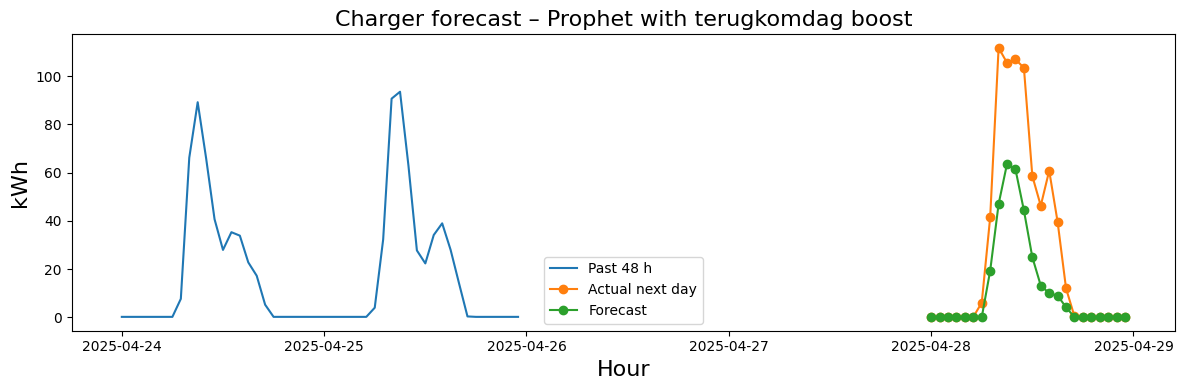

In [82]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# ───────────── config
TARGET_COL = "Chargers"
DAYS_TRAIN = 175
HRS_PER_DAY = 24
LOOK_BACK = DAYS_TRAIN * HRS_PER_DAY
N_FORECAST = 24
BOOST_FACTOR = 1.5  # multiplier for terugkomdag effect

def add_terugkomdag_feature(df):
    terugkomdagen = [
        datetime(2023, 9, 13), datetime(2023, 10, 26), datetime(2023, 11, 14), datetime(2023, 12, 20),
        datetime(2024, 1, 12), datetime(2024, 2, 7), datetime(2024, 3, 14), datetime(2024, 4, 16),
        datetime(2024, 5, 13), datetime(2024, 6, 7), datetime(2024, 10, 22), datetime(2024, 11, 28),
        datetime(2024, 12, 18), datetime(2025, 1, 10), datetime(2025, 2, 13), datetime(2025, 3, 18),
        datetime(2025, 4, 22), datetime(2025, 5, 12), datetime(2025, 6, 6)
    ]
    dates = {d.date() for d in terugkomdagen}
    df['is_terugkomdag'] = df['ds'].dt.date.isin(dates).astype(int)
    return df

if __name__ == "__main__":
    # Prepare dataframe
    df = df.copy()
    if 'ds' not in df.columns:
        df = df.reset_index().rename(columns={df.index.name or df.columns[0]: 'ds'})
    df['ds'] = pd.to_datetime(df['ds'])

    df_less = df.iloc[:-48]

    # Slice recent window and rename target
    df_recent = df_less.iloc[-(LOOK_BACK + N_FORECAST):].copy().reset_index(drop=True)
    df_recent = df_recent[['ds', TARGET_COL]].rename(columns={TARGET_COL: 'y'})

    # Add terugkomdag feature
    df_recent = add_terugkomdag_feature(df_recent)

    # Remove weekends
    df_recent = df_recent[df_recent['ds'].dt.dayofweek < 5].reset_index(drop=True)

    # Train/test split
    df_train = df_recent.iloc[:-N_FORECAST]
    df_test = df_recent.iloc[-N_FORECAST:]

    # Prophet model setup
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.add_seasonality(name='hourly', period=24, fourier_order=12)
    # Boost prior to emphasize terugkomdag effect
    model.add_regressor('is_terugkomdag', prior_scale=1.0)

    # Fit model
    model.fit(df_train[['ds', 'y', 'is_terugkomdag']])

    # Prepare future dataframe
    future = model.make_future_dataframe(periods=N_FORECAST*2, freq='H')
    future = future[future['ds'].dt.dayofweek < 5].reset_index(drop=True)
    future = future.iloc[:len(df_train) + N_FORECAST]
    future = add_terugkomdag_feature(future)

    # Predict
    forecast = model.predict(future)
    # Apply boost on terugkomdag predictions
    forecast.loc[forecast['is_terugkomdag'] == 1, 'yhat'] *= BOOST_FACTOR

    # Extract predictions and evaluate
    preds = forecast.iloc[-N_FORECAST:]['yhat'].clip(lower=0).values
    mae = mean_absolute_error(df_test['y'], preds)
    rmse = math.sqrt(mean_squared_error(df_test['y'], preds))
    r2 = r2_score(df_test['y'], preds)
    print(f"Prophet → MAE {mae:6.2f}  RMSE {rmse:6.2f}  R² {r2:6.2f}")

    # Plot results
    plt.figure(figsize=(12, 4))
    history = df_train.iloc[-(2*HRS_PER_DAY):]
    plt.plot(history['ds'], history['y'], label="Past 48 h")
    plt.plot(df_test['ds'], df_test['y'], '-o', label="Actual next day")
    plt.plot(df_test['ds'], preds, '-o', label="Forecast")
    plt.title("Charger forecast – Prophet with terugkomdag boost", fontsize=16)
    plt.xlabel("Hour", fontsize=16)
    plt.ylabel("kWh", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()
